In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/1st_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




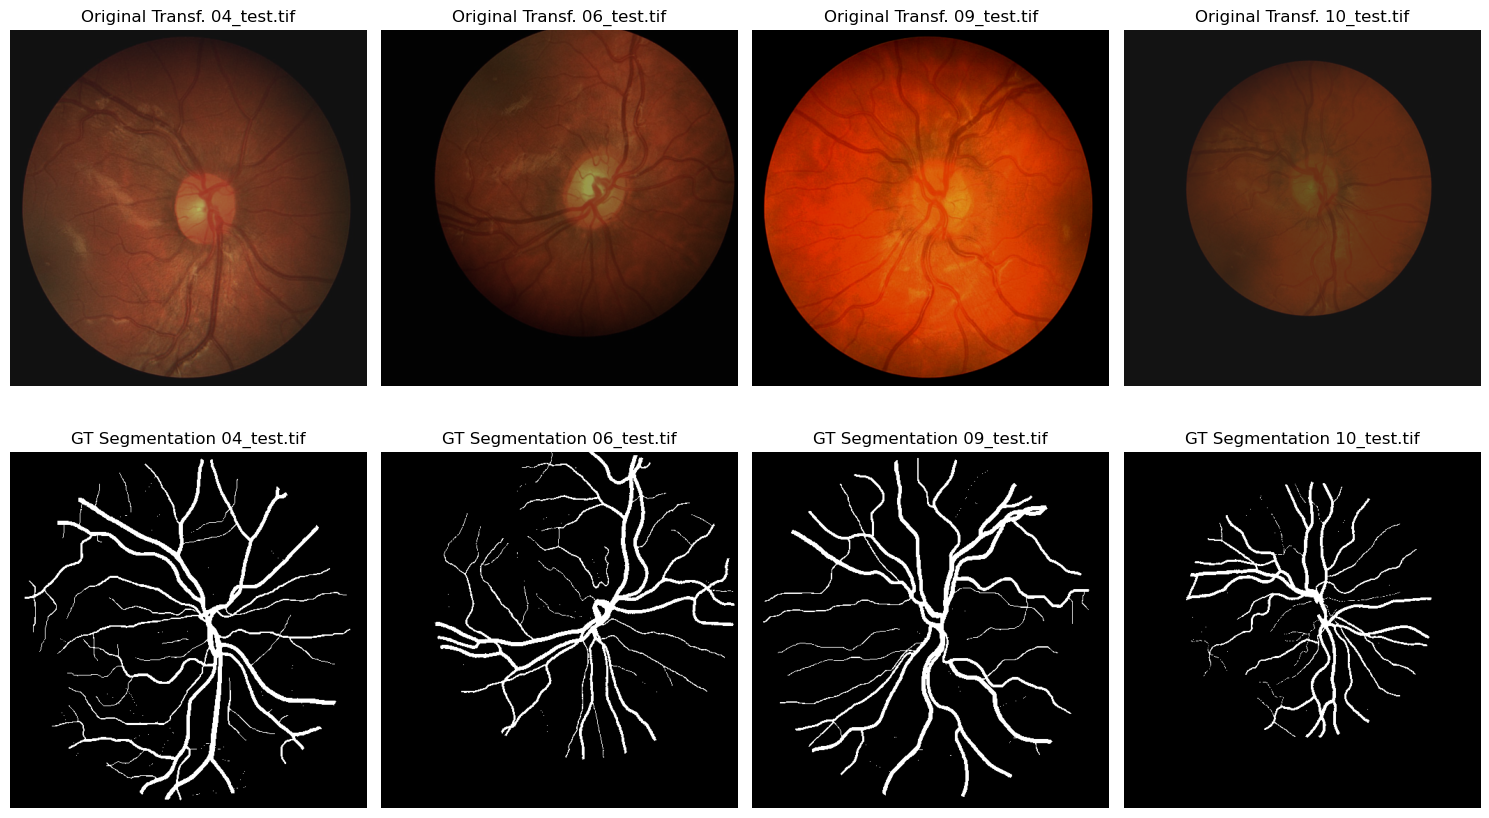

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1250

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.25, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 1/1250 | Training loss: 0.30000 | Validation loss: 0.30235 | Training accuracy: 92.14% | Validation accuracy: 92.64%




100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 2/1250 | Training loss: 0.30043 | Validation loss: 0.30404 | Training accuracy: 92.84% | Validation accuracy: 93.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 3/1250 | Training loss: 0.30058 | Validation loss: 0.30341 | Training accuracy: 93.26% | Validation accuracy: 94.44%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 4/1250 | Training loss: 0.29630 | Validation loss: 0.29953 | Training accuracy: 92.56% | Validation accuracy: 94.80%




100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 5/1250 | Training loss: 0.29869 | Validation loss: 0.30270 | Training accuracy: 93.70% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 6/1250 | Training loss: 0.29483 | Validation loss: 0.29018 | Training accuracy: 93.60% | Validation accuracy: 89.93%




100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 7/1250 | Training loss: 0.29014 | Validation loss: 0.29974 | Training accuracy: 93.13% | Validation accuracy: 92.89%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 8/1250 | Training loss: 0.28520 | Validation loss: 0.29160 | Training accuracy: 92.18% | Validation accuracy: 92.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 9/1250 | Training loss: 0.28318 | Validation loss: 0.28894 | Training accuracy: 92.46% | Validation accuracy: 91.92%




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 10/1250 | Training loss: 0.28397 | Validation loss: 0.27900 | Training accuracy: 93.88% | Validation accuracy: 92.59%




100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 11/1250 | Training loss: 0.27766 | Validation loss: 0.27827 | Training accuracy: 92.83% | Validation accuracy: 93.43%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 12/1250 | Training loss: 0.27539 | Validation loss: 0.27755 | Training accuracy: 93.22% | Validation accuracy: 91.97%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 13/1250 | Training loss: 0.27046 | Validation loss: 0.26747 | Training accuracy: 93.13% | Validation accuracy: 93.09%




100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 14/1250 | Training loss: 0.26413 | Validation loss: 0.26648 | Training accuracy: 93.54% | Validation accuracy: 95.69%




100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 15/1250 | Training loss: 0.25736 | Validation loss: 0.25916 | Training accuracy: 92.85% | Validation accuracy: 92.89%




100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 16/1250 | Training loss: 0.25255 | Validation loss: 0.25908 | Training accuracy: 93.00% | Validation accuracy: 91.93%




100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 17/1250 | Training loss: 0.24180 | Validation loss: 0.24571 | Training accuracy: 92.52% | Validation accuracy: 95.30%




100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 18/1250 | Training loss: 0.24203 | Validation loss: 0.26801 | Training accuracy: 93.76% | Validation accuracy: 92.78%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 19/1250 | Training loss: 0.23369 | Validation loss: 0.27868 | Training accuracy: 92.53% | Validation accuracy: 93.82%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 20/1250 | Training loss: 0.23242 | Validation loss: 0.24449 | Training accuracy: 93.16% | Validation accuracy: 92.53%




100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 21/1250 | Training loss: 0.21531 | Validation loss: 0.26167 | Training accuracy: 92.68% | Validation accuracy: 92.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 22/1250 | Training loss: 0.20431 | Validation loss: 0.23873 | Training accuracy: 92.50% | Validation accuracy: 93.14%




100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 23/1250 | Training loss: 0.20862 | Validation loss: 0.20923 | Training accuracy: 93.38% | Validation accuracy: 90.20%




100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 24/1250 | Training loss: 0.19570 | Validation loss: 0.21172 | Training accuracy: 93.00% | Validation accuracy: 93.70%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 25/1250 | Training loss: 0.18814 | Validation loss: 0.20538 | Training accuracy: 92.31% | Validation accuracy: 90.61%




100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 26/1250 | Training loss: 0.18030 | Validation loss: 0.24303 | Training accuracy: 93.44% | Validation accuracy: 92.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 27/1250 | Training loss: 0.18194 | Validation loss: 0.18687 | Training accuracy: 93.22% | Validation accuracy: 94.96%




100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 28/1250 | Training loss: 0.17765 | Validation loss: 0.18392 | Training accuracy: 92.95% | Validation accuracy: 93.74%




100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 29/1250 | Training loss: 0.17463 | Validation loss: 0.17786 | Training accuracy: 93.23% | Validation accuracy: 94.84%




100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 30/1250 | Training loss: 0.17101 | Validation loss: 0.20453 | Training accuracy: 93.76% | Validation accuracy: 91.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 31/1250 | Training loss: 0.16849 | Validation loss: 0.18394 | Training accuracy: 93.29% | Validation accuracy: 94.69%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 32/1250 | Training loss: 0.16635 | Validation loss: 0.18015 | Training accuracy: 92.52% | Validation accuracy: 90.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 33/1250 | Training loss: 0.16795 | Validation loss: 0.18361 | Training accuracy: 92.59% | Validation accuracy: 94.46%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch: 34/1250 | Training loss: 0.16752 | Validation loss: 0.25092 | Training accuracy: 93.71% | Validation accuracy: 92.65%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 35/1250 | Training loss: 0.17954 | Validation loss: 0.24282 | Training accuracy: 93.56% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 36/1250 | Training loss: 0.17148 | Validation loss: 0.26661 | Training accuracy: 93.84% | Validation accuracy: 92.03%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 37/1250 | Training loss: 0.16717 | Validation loss: 0.16777 | Training accuracy: 93.14% | Validation accuracy: 92.81%




100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 38/1250 | Training loss: 0.16863 | Validation loss: 0.21563 | Training accuracy: 92.53% | Validation accuracy: 93.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 39/1250 | Training loss: 0.15950 | Validation loss: 0.16648 | Training accuracy: 93.90% | Validation accuracy: 93.95%




100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 40/1250 | Training loss: 0.16060 | Validation loss: 0.16599 | Training accuracy: 93.73% | Validation accuracy: 92.13%




100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 41/1250 | Training loss: 0.16446 | Validation loss: 0.16160 | Training accuracy: 92.87% | Validation accuracy: 95.58%




100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 42/1250 | Training loss: 0.16572 | Validation loss: 0.17324 | Training accuracy: 93.55% | Validation accuracy: 93.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 43/1250 | Training loss: 0.16697 | Validation loss: 0.15450 | Training accuracy: 93.32% | Validation accuracy: 96.48%




100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 44/1250 | Training loss: 0.16183 | Validation loss: 0.16787 | Training accuracy: 92.81% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 45/1250 | Training loss: 0.15599 | Validation loss: 0.16037 | Training accuracy: 92.64% | Validation accuracy: 93.81%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 46/1250 | Training loss: 0.16483 | Validation loss: 0.16306 | Training accuracy: 91.41% | Validation accuracy: 94.76%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 47/1250 | Training loss: 0.15722 | Validation loss: 0.19529 | Training accuracy: 93.57% | Validation accuracy: 93.67%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 48/1250 | Training loss: 0.15233 | Validation loss: 0.16253 | Training accuracy: 94.00% | Validation accuracy: 94.08%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 49/1250 | Training loss: 0.15678 | Validation loss: 0.16610 | Training accuracy: 92.67% | Validation accuracy: 94.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 50/1250 | Training loss: 0.15090 | Validation loss: 0.16387 | Training accuracy: 94.59% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 51/1250 | Training loss: 0.15109 | Validation loss: 0.17027 | Training accuracy: 95.37% | Validation accuracy: 95.21%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch: 52/1250 | Training loss: 0.15164 | Validation loss: 0.16642 | Training accuracy: 95.08% | Validation accuracy: 93.97%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 53/1250 | Training loss: 0.14912 | Validation loss: 0.15255 | Training accuracy: 96.53% | Validation accuracy: 95.90%




100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 54/1250 | Training loss: 0.14658 | Validation loss: 0.14775 | Training accuracy: 95.89% | Validation accuracy: 95.49%




100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 55/1250 | Training loss: 0.14663 | Validation loss: 0.14863 | Training accuracy: 95.65% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 56/1250 | Training loss: 0.14712 | Validation loss: 0.14887 | Training accuracy: 95.80% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 57/1250 | Training loss: 0.14391 | Validation loss: 0.15059 | Training accuracy: 96.84% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 58/1250 | Training loss: 0.14528 | Validation loss: 0.20643 | Training accuracy: 96.55% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 59/1250 | Training loss: 0.14114 | Validation loss: 0.14546 | Training accuracy: 96.96% | Validation accuracy: 95.36%




100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 60/1250 | Training loss: 0.14810 | Validation loss: 0.14368 | Training accuracy: 95.53% | Validation accuracy: 96.55%




100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 61/1250 | Training loss: 0.14223 | Validation loss: 0.15496 | Training accuracy: 96.58% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 62/1250 | Training loss: 0.14158 | Validation loss: 0.14592 | Training accuracy: 97.00% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 63/1250 | Training loss: 0.14354 | Validation loss: 0.14741 | Training accuracy: 96.38% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 64/1250 | Training loss: 0.14410 | Validation loss: 0.14676 | Training accuracy: 96.03% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 65/1250 | Training loss: 0.14411 | Validation loss: 0.14651 | Training accuracy: 95.77% | Validation accuracy: 95.27%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 66/1250 | Training loss: 0.14317 | Validation loss: 0.14181 | Training accuracy: 95.92% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 67/1250 | Training loss: 0.13971 | Validation loss: 0.14856 | Training accuracy: 96.21% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 68/1250 | Training loss: 0.14024 | Validation loss: 0.14448 | Training accuracy: 96.15% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 69/1250 | Training loss: 0.13986 | Validation loss: 0.13984 | Training accuracy: 95.96% | Validation accuracy: 96.03%




100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 70/1250 | Training loss: 0.13921 | Validation loss: 0.13551 | Training accuracy: 95.95% | Validation accuracy: 96.83%




100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 71/1250 | Training loss: 0.13698 | Validation loss: 0.13893 | Training accuracy: 96.79% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 72/1250 | Training loss: 0.13774 | Validation loss: 0.16652 | Training accuracy: 96.55% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 73/1250 | Training loss: 0.13683 | Validation loss: 0.16037 | Training accuracy: 96.71% | Validation accuracy: 94.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 74/1250 | Training loss: 0.13985 | Validation loss: 0.13919 | Training accuracy: 96.43% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 75/1250 | Training loss: 0.13893 | Validation loss: 0.14513 | Training accuracy: 96.02% | Validation accuracy: 95.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 76/1250 | Training loss: 0.13476 | Validation loss: 0.14363 | Training accuracy: 97.00% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 77/1250 | Training loss: 0.13851 | Validation loss: 0.13354 | Training accuracy: 96.47% | Validation accuracy: 96.71%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 78/1250 | Training loss: 0.13933 | Validation loss: 0.14671 | Training accuracy: 95.79% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 79/1250 | Training loss: 0.13469 | Validation loss: 0.19250 | Training accuracy: 96.40% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 80/1250 | Training loss: 0.13685 | Validation loss: 0.18809 | Training accuracy: 96.28% | Validation accuracy: 94.67%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 81/1250 | Training loss: 0.13636 | Validation loss: 0.13797 | Training accuracy: 96.29% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 82/1250 | Training loss: 0.13771 | Validation loss: 0.14690 | Training accuracy: 95.89% | Validation accuracy: 95.55%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 83/1250 | Training loss: 0.13381 | Validation loss: 0.15223 | Training accuracy: 96.67% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 84/1250 | Training loss: 0.13394 | Validation loss: 0.13790 | Training accuracy: 96.49% | Validation accuracy: 95.60%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 85/1250 | Training loss: 0.13472 | Validation loss: 0.14262 | Training accuracy: 96.60% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 86/1250 | Training loss: 0.13390 | Validation loss: 0.14438 | Training accuracy: 96.37% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 87/1250 | Training loss: 0.13471 | Validation loss: 0.16262 | Training accuracy: 95.98% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 88/1250 | Training loss: 0.13367 | Validation loss: 0.13602 | Training accuracy: 96.55% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 89/1250 | Training loss: 0.13562 | Validation loss: 0.13172 | Training accuracy: 96.15% | Validation accuracy: 96.80%




100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 90/1250 | Training loss: 0.13148 | Validation loss: 0.13314 | Training accuracy: 96.30% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 91/1250 | Training loss: 0.13246 | Validation loss: 0.13945 | Training accuracy: 96.33% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 92/1250 | Training loss: 0.12931 | Validation loss: 0.13277 | Training accuracy: 96.71% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 93/1250 | Training loss: 0.13009 | Validation loss: 0.13873 | Training accuracy: 96.49% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch: 94/1250 | Training loss: 0.13087 | Validation loss: 0.13612 | Training accuracy: 96.73% | Validation accuracy: 95.27%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 95/1250 | Training loss: 0.12888 | Validation loss: 0.12889 | Training accuracy: 96.97% | Validation accuracy: 96.57%




100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 96/1250 | Training loss: 0.12807 | Validation loss: 0.12812 | Training accuracy: 96.93% | Validation accuracy: 96.58%




100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 97/1250 | Training loss: 0.13087 | Validation loss: 0.13242 | Training accuracy: 96.14% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 98/1250 | Training loss: 0.12824 | Validation loss: 0.13334 | Training accuracy: 96.52% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 99/1250 | Training loss: 0.12791 | Validation loss: 0.12599 | Training accuracy: 97.07% | Validation accuracy: 98.01%




100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 100/1250 | Training loss: 0.12845 | Validation loss: 0.12957 | Training accuracy: 96.51% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 101/1250 | Training loss: 0.12628 | Validation loss: 0.13099 | Training accuracy: 96.77% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 102/1250 | Training loss: 0.12644 | Validation loss: 0.13997 | Training accuracy: 96.96% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 103/1250 | Training loss: 0.13068 | Validation loss: 0.13424 | Training accuracy: 96.88% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 104/1250 | Training loss: 0.12711 | Validation loss: 0.12905 | Training accuracy: 96.96% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 105/1250 | Training loss: 0.12745 | Validation loss: 0.13656 | Training accuracy: 96.83% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 106/1250 | Training loss: 0.13145 | Validation loss: 0.14610 | Training accuracy: 96.08% | Validation accuracy: 95.05%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 107/1250 | Training loss: 0.12816 | Validation loss: 0.14577 | Training accuracy: 96.34% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 108/1250 | Training loss: 0.12922 | Validation loss: 0.13291 | Training accuracy: 96.35% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 109/1250 | Training loss: 0.12836 | Validation loss: 0.13406 | Training accuracy: 96.30% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 110/1250 | Training loss: 0.12822 | Validation loss: 0.12937 | Training accuracy: 96.67% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 111/1250 | Training loss: 0.12565 | Validation loss: 0.12523 | Training accuracy: 96.91% | Validation accuracy: 97.29%




100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 112/1250 | Training loss: 0.12532 | Validation loss: 0.12932 | Training accuracy: 96.89% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 113/1250 | Training loss: 0.12410 | Validation loss: 0.12830 | Training accuracy: 97.05% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 114/1250 | Training loss: 0.12708 | Validation loss: 0.12750 | Training accuracy: 96.00% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 115/1250 | Training loss: 0.12584 | Validation loss: 0.12718 | Training accuracy: 96.31% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 116/1250 | Training loss: 0.12658 | Validation loss: 0.12339 | Training accuracy: 95.94% | Validation accuracy: 97.32%




100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 117/1250 | Training loss: 0.12100 | Validation loss: 0.12422 | Training accuracy: 97.10% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 118/1250 | Training loss: 0.12246 | Validation loss: 0.12509 | Training accuracy: 96.79% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 119/1250 | Training loss: 0.12289 | Validation loss: 0.12816 | Training accuracy: 96.74% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 120/1250 | Training loss: 0.12200 | Validation loss: 0.12172 | Training accuracy: 96.85% | Validation accuracy: 96.84%




100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 121/1250 | Training loss: 0.12364 | Validation loss: 0.12314 | Training accuracy: 96.73% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 122/1250 | Training loss: 0.12076 | Validation loss: 0.21859 | Training accuracy: 97.04% | Validation accuracy: 74.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 123/1250 | Training loss: 0.12188 | Validation loss: 0.16876 | Training accuracy: 97.29% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 124/1250 | Training loss: 0.14275 | Validation loss: 0.14349 | Training accuracy: 95.39% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 125/1250 | Training loss: 0.13555 | Validation loss: 0.20682 | Training accuracy: 96.07% | Validation accuracy: 91.29%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 126/1250 | Training loss: 0.14030 | Validation loss: 0.14671 | Training accuracy: 96.02% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 127/1250 | Training loss: 0.13806 | Validation loss: 0.13993 | Training accuracy: 95.99% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 128/1250 | Training loss: 0.13866 | Validation loss: 0.14906 | Training accuracy: 95.80% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 129/1250 | Training loss: 0.13327 | Validation loss: 0.17019 | Training accuracy: 95.90% | Validation accuracy: 93.77%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 130/1250 | Training loss: 0.13263 | Validation loss: 0.14900 | Training accuracy: 96.46% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 131/1250 | Training loss: 0.12999 | Validation loss: 0.17650 | Training accuracy: 96.47% | Validation accuracy: 95.29%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 132/1250 | Training loss: 0.13242 | Validation loss: 0.13320 | Training accuracy: 95.70% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 133/1250 | Training loss: 0.12992 | Validation loss: 0.13194 | Training accuracy: 95.66% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 134/1250 | Training loss: 0.12918 | Validation loss: 0.13122 | Training accuracy: 95.95% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 135/1250 | Training loss: 0.13075 | Validation loss: 0.12244 | Training accuracy: 96.07% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 136/1250 | Training loss: 0.12782 | Validation loss: 0.12369 | Training accuracy: 96.33% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 137/1250 | Training loss: 0.12860 | Validation loss: 0.12674 | Training accuracy: 96.39% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 138/1250 | Training loss: 0.12630 | Validation loss: 0.15682 | Training accuracy: 96.77% | Validation accuracy: 95.26%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 139/1250 | Training loss: 0.12678 | Validation loss: 0.12916 | Training accuracy: 97.25% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 140/1250 | Training loss: 0.12316 | Validation loss: 0.16598 | Training accuracy: 97.06% | Validation accuracy: 95.13%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 141/1250 | Training loss: 0.13484 | Validation loss: 0.12190 | Training accuracy: 96.04% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 142/1250 | Training loss: 0.13029 | Validation loss: 0.13308 | Training accuracy: 95.66% | Validation accuracy: 95.12%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 143/1250 | Training loss: 0.12753 | Validation loss: 0.16230 | Training accuracy: 96.57% | Validation accuracy: 92.61%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 144/1250 | Training loss: 0.12549 | Validation loss: 0.13720 | Training accuracy: 96.63% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 145/1250 | Training loss: 0.12459 | Validation loss: 0.19676 | Training accuracy: 96.68% | Validation accuracy: 93.77%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 146/1250 | Training loss: 0.12670 | Validation loss: 0.17472 | Training accuracy: 95.95% | Validation accuracy: 93.90%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 147/1250 | Training loss: 0.12377 | Validation loss: 0.16732 | Training accuracy: 95.94% | Validation accuracy: 95.35%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 148/1250 | Training loss: 0.12096 | Validation loss: 0.13244 | Training accuracy: 96.80% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 149/1250 | Training loss: 0.12706 | Validation loss: 0.13250 | Training accuracy: 96.65% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 150/1250 | Training loss: 0.12177 | Validation loss: 0.11831 | Training accuracy: 96.72% | Validation accuracy: 97.45%




100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 151/1250 | Training loss: 0.12149 | Validation loss: 0.12273 | Training accuracy: 96.64% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 152/1250 | Training loss: 0.12023 | Validation loss: 0.11983 | Training accuracy: 96.30% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 153/1250 | Training loss: 0.11962 | Validation loss: 0.11899 | Training accuracy: 97.26% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 154/1250 | Training loss: 0.11852 | Validation loss: 0.12490 | Training accuracy: 96.83% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 155/1250 | Training loss: 0.11676 | Validation loss: 0.12343 | Training accuracy: 96.94% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 156/1250 | Training loss: 0.11684 | Validation loss: 0.12010 | Training accuracy: 96.72% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 157/1250 | Training loss: 0.11645 | Validation loss: 0.11855 | Training accuracy: 96.49% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 158/1250 | Training loss: 0.11632 | Validation loss: 0.12182 | Training accuracy: 96.79% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 159/1250 | Training loss: 0.11551 | Validation loss: 0.11957 | Training accuracy: 96.88% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 160/1250 | Training loss: 0.11498 | Validation loss: 0.11395 | Training accuracy: 97.08% | Validation accuracy: 97.11%




100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 161/1250 | Training loss: 0.11375 | Validation loss: 0.11711 | Training accuracy: 97.17% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 162/1250 | Training loss: 0.11784 | Validation loss: 0.11538 | Training accuracy: 97.34% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 163/1250 | Training loss: 0.11420 | Validation loss: 0.12029 | Training accuracy: 97.19% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 164/1250 | Training loss: 0.11920 | Validation loss: 0.12310 | Training accuracy: 96.29% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 165/1250 | Training loss: 0.11864 | Validation loss: 0.13707 | Training accuracy: 96.28% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 166/1250 | Training loss: 0.11660 | Validation loss: 0.13366 | Training accuracy: 96.59% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch: 167/1250 | Training loss: 0.11584 | Validation loss: 0.11858 | Training accuracy: 96.87% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 168/1250 | Training loss: 0.11316 | Validation loss: 0.11202 | Training accuracy: 97.53% | Validation accuracy: 97.29%




100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 169/1250 | Training loss: 0.11464 | Validation loss: 0.13430 | Training accuracy: 96.57% | Validation accuracy: 95.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 170/1250 | Training loss: 0.11306 | Validation loss: 0.12157 | Training accuracy: 96.82% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 171/1250 | Training loss: 0.11241 | Validation loss: 0.10993 | Training accuracy: 97.03% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 172/1250 | Training loss: 0.11126 | Validation loss: 0.11133 | Training accuracy: 97.39% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 173/1250 | Training loss: 0.11023 | Validation loss: 0.11825 | Training accuracy: 97.30% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 174/1250 | Training loss: 0.11114 | Validation loss: 0.11258 | Training accuracy: 96.76% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 175/1250 | Training loss: 0.11261 | Validation loss: 0.11691 | Training accuracy: 96.53% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 176/1250 | Training loss: 0.11188 | Validation loss: 0.10813 | Training accuracy: 96.84% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 177/1250 | Training loss: 0.11353 | Validation loss: 0.11087 | Training accuracy: 97.19% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 178/1250 | Training loss: 0.11779 | Validation loss: 0.11695 | Training accuracy: 96.24% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 179/1250 | Training loss: 0.11213 | Validation loss: 0.12037 | Training accuracy: 97.12% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 180/1250 | Training loss: 0.11203 | Validation loss: 0.11641 | Training accuracy: 96.92% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 181/1250 | Training loss: 0.11366 | Validation loss: 0.12151 | Training accuracy: 96.41% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 182/1250 | Training loss: 0.11160 | Validation loss: 0.11065 | Training accuracy: 96.96% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 183/1250 | Training loss: 0.11328 | Validation loss: 0.11906 | Training accuracy: 97.07% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 184/1250 | Training loss: 0.11239 | Validation loss: 0.11262 | Training accuracy: 96.57% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 185/1250 | Training loss: 0.11010 | Validation loss: 0.11614 | Training accuracy: 96.64% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 186/1250 | Training loss: 0.11209 | Validation loss: 0.11813 | Training accuracy: 96.95% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 187/1250 | Training loss: 0.11236 | Validation loss: 0.11862 | Training accuracy: 97.21% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 188/1250 | Training loss: 0.10930 | Validation loss: 0.10997 | Training accuracy: 96.97% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 189/1250 | Training loss: 0.10858 | Validation loss: 0.11191 | Training accuracy: 97.28% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 190/1250 | Training loss: 0.11130 | Validation loss: 0.12101 | Training accuracy: 96.63% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 191/1250 | Training loss: 0.10977 | Validation loss: 0.11163 | Training accuracy: 96.87% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 192/1250 | Training loss: 0.10672 | Validation loss: 0.11331 | Training accuracy: 97.08% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 193/1250 | Training loss: 0.10694 | Validation loss: 0.12120 | Training accuracy: 96.98% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 194/1250 | Training loss: 0.10666 | Validation loss: 0.10475 | Training accuracy: 97.04% | Validation accuracy: 97.05%




100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 195/1250 | Training loss: 0.10555 | Validation loss: 0.11964 | Training accuracy: 96.99% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 196/1250 | Training loss: 0.10374 | Validation loss: 0.12767 | Training accuracy: 97.75% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 197/1250 | Training loss: 0.10561 | Validation loss: 0.11491 | Training accuracy: 97.34% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 198/1250 | Training loss: 0.10492 | Validation loss: 0.10779 | Training accuracy: 97.23% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 199/1250 | Training loss: 0.10574 | Validation loss: 0.10909 | Training accuracy: 96.92% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 200/1250 | Training loss: 0.10402 | Validation loss: 0.10706 | Training accuracy: 97.74% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 201/1250 | Training loss: 0.10624 | Validation loss: 0.11698 | Training accuracy: 97.01% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 202/1250 | Training loss: 0.10412 | Validation loss: 0.10684 | Training accuracy: 97.13% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 203/1250 | Training loss: 0.10576 | Validation loss: 0.10676 | Training accuracy: 97.09% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 204/1250 | Training loss: 0.10399 | Validation loss: 0.10578 | Training accuracy: 97.15% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 205/1250 | Training loss: 0.10500 | Validation loss: 0.11035 | Training accuracy: 96.83% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 206/1250 | Training loss: 0.10322 | Validation loss: 0.10411 | Training accuracy: 97.27% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 207/1250 | Training loss: 0.10280 | Validation loss: 0.10363 | Training accuracy: 97.15% | Validation accuracy: 97.82%




100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 208/1250 | Training loss: 0.10309 | Validation loss: 0.10123 | Training accuracy: 97.18% | Validation accuracy: 98.19%




100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 209/1250 | Training loss: 0.10198 | Validation loss: 0.10312 | Training accuracy: 97.67% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 210/1250 | Training loss: 0.10122 | Validation loss: 0.10460 | Training accuracy: 97.46% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 211/1250 | Training loss: 0.10155 | Validation loss: 0.10413 | Training accuracy: 97.38% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 212/1250 | Training loss: 0.10255 | Validation loss: 0.10569 | Training accuracy: 96.96% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 213/1250 | Training loss: 0.10117 | Validation loss: 0.10642 | Training accuracy: 97.34% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 214/1250 | Training loss: 0.10270 | Validation loss: 0.11181 | Training accuracy: 97.49% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 215/1250 | Training loss: 0.10392 | Validation loss: 0.10886 | Training accuracy: 97.24% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 216/1250 | Training loss: 0.10739 | Validation loss: 0.11482 | Training accuracy: 96.96% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 217/1250 | Training loss: 0.10531 | Validation loss: 0.11766 | Training accuracy: 96.95% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 218/1250 | Training loss: 0.10839 | Validation loss: 0.11450 | Training accuracy: 97.20% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 219/1250 | Training loss: 0.10592 | Validation loss: 0.11725 | Training accuracy: 96.67% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 220/1250 | Training loss: 0.10329 | Validation loss: 0.11594 | Training accuracy: 97.23% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 221/1250 | Training loss: 0.10800 | Validation loss: 0.12058 | Training accuracy: 96.83% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 222/1250 | Training loss: 0.10623 | Validation loss: 0.12863 | Training accuracy: 96.89% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 223/1250 | Training loss: 0.10240 | Validation loss: 0.10652 | Training accuracy: 97.42% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 224/1250 | Training loss: 0.10334 | Validation loss: 0.10495 | Training accuracy: 96.85% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 225/1250 | Training loss: 0.10057 | Validation loss: 0.10418 | Training accuracy: 97.22% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 226/1250 | Training loss: 0.10240 | Validation loss: 0.10374 | Training accuracy: 97.03% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 227/1250 | Training loss: 0.10128 | Validation loss: 0.09843 | Training accuracy: 97.32% | Validation accuracy: 98.49%




100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 228/1250 | Training loss: 0.09998 | Validation loss: 0.10207 | Training accuracy: 97.50% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 229/1250 | Training loss: 0.09995 | Validation loss: 0.10393 | Training accuracy: 97.34% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 230/1250 | Training loss: 0.10033 | Validation loss: 0.09872 | Training accuracy: 97.20% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 231/1250 | Training loss: 0.10075 | Validation loss: 0.09723 | Training accuracy: 97.44% | Validation accuracy: 98.08%




100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 232/1250 | Training loss: 0.09975 | Validation loss: 0.10781 | Training accuracy: 97.45% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 233/1250 | Training loss: 0.10118 | Validation loss: 0.10374 | Training accuracy: 96.90% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 234/1250 | Training loss: 0.09955 | Validation loss: 0.11389 | Training accuracy: 97.28% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 235/1250 | Training loss: 0.10025 | Validation loss: 0.10655 | Training accuracy: 97.46% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 236/1250 | Training loss: 0.09812 | Validation loss: 0.09812 | Training accuracy: 97.28% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 237/1250 | Training loss: 0.10295 | Validation loss: 0.10128 | Training accuracy: 96.82% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 238/1250 | Training loss: 0.09704 | Validation loss: 0.10660 | Training accuracy: 97.66% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 239/1250 | Training loss: 0.09922 | Validation loss: 0.11531 | Training accuracy: 96.93% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 240/1250 | Training loss: 0.09821 | Validation loss: 0.09577 | Training accuracy: 97.09% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 241/1250 | Training loss: 0.09866 | Validation loss: 0.21205 | Training accuracy: 97.23% | Validation accuracy: 94.39%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 242/1250 | Training loss: 0.09863 | Validation loss: 0.10429 | Training accuracy: 97.07% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 243/1250 | Training loss: 0.09875 | Validation loss: 0.10648 | Training accuracy: 96.85% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 244/1250 | Training loss: 0.09749 | Validation loss: 0.09854 | Training accuracy: 97.20% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 245/1250 | Training loss: 0.09861 | Validation loss: 0.10015 | Training accuracy: 97.54% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 246/1250 | Training loss: 0.09757 | Validation loss: 0.10078 | Training accuracy: 97.17% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 247/1250 | Training loss: 0.09810 | Validation loss: 0.09715 | Training accuracy: 96.91% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 248/1250 | Training loss: 0.09857 | Validation loss: 0.10270 | Training accuracy: 97.33% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 249/1250 | Training loss: 0.09689 | Validation loss: 0.10280 | Training accuracy: 97.40% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 250/1250 | Training loss: 0.09631 | Validation loss: 0.09715 | Training accuracy: 97.37% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 251/1250 | Training loss: 0.09716 | Validation loss: 0.09755 | Training accuracy: 97.27% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 252/1250 | Training loss: 0.09544 | Validation loss: 0.09507 | Training accuracy: 97.60% | Validation accuracy: 97.97%




100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 253/1250 | Training loss: 0.09575 | Validation loss: 0.10887 | Training accuracy: 97.47% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 254/1250 | Training loss: 0.09645 | Validation loss: 0.09766 | Training accuracy: 97.59% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 255/1250 | Training loss: 0.10287 | Validation loss: 0.09803 | Training accuracy: 96.50% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 256/1250 | Training loss: 0.09676 | Validation loss: 0.09789 | Training accuracy: 97.42% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 257/1250 | Training loss: 0.09568 | Validation loss: 0.10288 | Training accuracy: 97.55% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 258/1250 | Training loss: 0.09707 | Validation loss: 0.09517 | Training accuracy: 96.99% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 259/1250 | Training loss: 0.09636 | Validation loss: 0.10678 | Training accuracy: 97.40% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 260/1250 | Training loss: 0.10247 | Validation loss: 0.10351 | Training accuracy: 96.92% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 261/1250 | Training loss: 0.09615 | Validation loss: 0.09777 | Training accuracy: 97.76% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 262/1250 | Training loss: 0.09551 | Validation loss: 0.10247 | Training accuracy: 97.53% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 263/1250 | Training loss: 0.09654 | Validation loss: 0.10314 | Training accuracy: 97.22% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 264/1250 | Training loss: 0.09529 | Validation loss: 0.11299 | Training accuracy: 97.44% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 265/1250 | Training loss: 0.09661 | Validation loss: 0.09987 | Training accuracy: 96.99% | Validation accuracy: 96.16%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 266/1250 | Training loss: 0.09753 | Validation loss: 0.10135 | Training accuracy: 97.22% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 267/1250 | Training loss: 0.09807 | Validation loss: 0.10006 | Training accuracy: 96.98% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 268/1250 | Training loss: 0.09496 | Validation loss: 0.10939 | Training accuracy: 97.53% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 269/1250 | Training loss: 0.09442 | Validation loss: 0.09358 | Training accuracy: 97.21% | Validation accuracy: 97.19%




100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 270/1250 | Training loss: 0.09470 | Validation loss: 0.09435 | Training accuracy: 97.09% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 271/1250 | Training loss: 0.09508 | Validation loss: 0.10000 | Training accuracy: 97.60% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 272/1250 | Training loss: 0.09207 | Validation loss: 0.09513 | Training accuracy: 97.57% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 273/1250 | Training loss: 0.09245 | Validation loss: 0.09612 | Training accuracy: 97.67% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 274/1250 | Training loss: 0.09182 | Validation loss: 0.09732 | Training accuracy: 97.47% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 275/1250 | Training loss: 0.09277 | Validation loss: 0.10178 | Training accuracy: 97.31% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 276/1250 | Training loss: 0.09178 | Validation loss: 0.09234 | Training accuracy: 97.48% | Validation accuracy: 98.52%




100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 277/1250 | Training loss: 0.09394 | Validation loss: 0.09512 | Training accuracy: 97.33% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 278/1250 | Training loss: 0.09207 | Validation loss: 0.09442 | Training accuracy: 97.21% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 279/1250 | Training loss: 0.09358 | Validation loss: 0.09691 | Training accuracy: 97.09% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 280/1250 | Training loss: 0.09199 | Validation loss: 0.09482 | Training accuracy: 97.20% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 281/1250 | Training loss: 0.09123 | Validation loss: 0.09522 | Training accuracy: 97.51% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 282/1250 | Training loss: 0.09059 | Validation loss: 0.09828 | Training accuracy: 97.49% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 283/1250 | Training loss: 0.09075 | Validation loss: 0.09543 | Training accuracy: 97.55% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 284/1250 | Training loss: 0.08916 | Validation loss: 0.09056 | Training accuracy: 97.80% | Validation accuracy: 98.43%




100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 285/1250 | Training loss: 0.08918 | Validation loss: 0.09266 | Training accuracy: 97.63% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 286/1250 | Training loss: 0.09273 | Validation loss: 0.09577 | Training accuracy: 97.17% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 287/1250 | Training loss: 0.09189 | Validation loss: 0.09829 | Training accuracy: 97.08% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 288/1250 | Training loss: 0.09079 | Validation loss: 0.09663 | Training accuracy: 97.28% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 289/1250 | Training loss: 0.09187 | Validation loss: 0.09248 | Training accuracy: 97.42% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 290/1250 | Training loss: 0.09194 | Validation loss: 0.08951 | Training accuracy: 97.34% | Validation accuracy: 97.57%




100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 291/1250 | Training loss: 0.09039 | Validation loss: 0.09449 | Training accuracy: 97.45% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 292/1250 | Training loss: 0.09071 | Validation loss: 0.09351 | Training accuracy: 97.73% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 293/1250 | Training loss: 0.09110 | Validation loss: 0.09609 | Training accuracy: 97.22% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 294/1250 | Training loss: 0.09028 | Validation loss: 0.09436 | Training accuracy: 97.42% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 295/1250 | Training loss: 0.08935 | Validation loss: 0.09683 | Training accuracy: 97.68% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 296/1250 | Training loss: 0.08715 | Validation loss: 0.09494 | Training accuracy: 98.02% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 297/1250 | Training loss: 0.08977 | Validation loss: 0.09846 | Training accuracy: 97.50% | Validation accuracy: 98.74%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 298/1250 | Training loss: 0.08987 | Validation loss: 0.09640 | Training accuracy: 97.30% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 299/1250 | Training loss: 0.08938 | Validation loss: 0.09217 | Training accuracy: 97.25% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 300/1250 | Training loss: 0.08850 | Validation loss: 0.09532 | Training accuracy: 97.42% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 301/1250 | Training loss: 0.08841 | Validation loss: 0.09154 | Training accuracy: 97.59% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 302/1250 | Training loss: 0.08812 | Validation loss: 0.09295 | Training accuracy: 97.40% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 303/1250 | Training loss: 0.08740 | Validation loss: 0.09184 | Training accuracy: 97.69% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 304/1250 | Training loss: 0.08829 | Validation loss: 0.09131 | Training accuracy: 97.48% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 305/1250 | Training loss: 0.08859 | Validation loss: 0.09162 | Training accuracy: 97.41% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 306/1250 | Training loss: 0.09010 | Validation loss: 0.10505 | Training accuracy: 97.00% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 307/1250 | Training loss: 0.08769 | Validation loss: 0.08925 | Training accuracy: 97.67% | Validation accuracy: 97.30%




100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 308/1250 | Training loss: 0.08642 | Validation loss: 0.09289 | Training accuracy: 97.85% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 309/1250 | Training loss: 0.08886 | Validation loss: 0.09085 | Training accuracy: 97.02% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 310/1250 | Training loss: 0.08730 | Validation loss: 0.08842 | Training accuracy: 97.54% | Validation accuracy: 96.98%




100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 311/1250 | Training loss: 0.08662 | Validation loss: 0.08938 | Training accuracy: 97.74% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 312/1250 | Training loss: 0.08620 | Validation loss: 0.08781 | Training accuracy: 97.80% | Validation accuracy: 98.42%




100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 313/1250 | Training loss: 0.08596 | Validation loss: 0.09041 | Training accuracy: 97.62% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 314/1250 | Training loss: 0.08770 | Validation loss: 0.09673 | Training accuracy: 97.26% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 315/1250 | Training loss: 0.08671 | Validation loss: 0.08811 | Training accuracy: 97.75% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 316/1250 | Training loss: 0.08606 | Validation loss: 0.09648 | Training accuracy: 97.69% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 317/1250 | Training loss: 0.08637 | Validation loss: 0.08779 | Training accuracy: 97.40% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 318/1250 | Training loss: 0.08692 | Validation loss: 0.09409 | Training accuracy: 97.31% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 319/1250 | Training loss: 0.08719 | Validation loss: 0.08778 | Training accuracy: 97.62% | Validation accuracy: 97.74%




100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 320/1250 | Training loss: 0.08451 | Validation loss: 0.09053 | Training accuracy: 97.75% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 321/1250 | Training loss: 0.08501 | Validation loss: 0.08845 | Training accuracy: 97.64% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 322/1250 | Training loss: 0.08764 | Validation loss: 0.08723 | Training accuracy: 97.25% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 323/1250 | Training loss: 0.08720 | Validation loss: 0.08308 | Training accuracy: 97.48% | Validation accuracy: 98.07%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 324/1250 | Training loss: 0.08697 | Validation loss: 0.09396 | Training accuracy: 97.34% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 325/1250 | Training loss: 0.08517 | Validation loss: 0.09228 | Training accuracy: 97.60% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 326/1250 | Training loss: 0.08748 | Validation loss: 0.09100 | Training accuracy: 97.57% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 327/1250 | Training loss: 0.08626 | Validation loss: 0.09025 | Training accuracy: 97.35% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 328/1250 | Training loss: 0.08611 | Validation loss: 0.08716 | Training accuracy: 97.50% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 329/1250 | Training loss: 0.08486 | Validation loss: 0.08897 | Training accuracy: 97.56% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 330/1250 | Training loss: 0.09037 | Validation loss: 0.09005 | Training accuracy: 97.15% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 331/1250 | Training loss: 0.08522 | Validation loss: 0.08999 | Training accuracy: 97.63% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 332/1250 | Training loss: 0.08565 | Validation loss: 0.08778 | Training accuracy: 97.51% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 333/1250 | Training loss: 0.08637 | Validation loss: 0.08644 | Training accuracy: 97.26% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 334/1250 | Training loss: 0.08494 | Validation loss: 0.08782 | Training accuracy: 97.50% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 335/1250 | Training loss: 0.08676 | Validation loss: 0.08919 | Training accuracy: 97.26% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 336/1250 | Training loss: 0.08567 | Validation loss: 0.09120 | Training accuracy: 97.36% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 337/1250 | Training loss: 0.08497 | Validation loss: 0.09650 | Training accuracy: 97.27% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 338/1250 | Training loss: 0.08549 | Validation loss: 0.09383 | Training accuracy: 97.42% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 339/1250 | Training loss: 0.08554 | Validation loss: 0.08857 | Training accuracy: 97.21% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 340/1250 | Training loss: 0.08394 | Validation loss: 0.08254 | Training accuracy: 97.58% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 341/1250 | Training loss: 0.08297 | Validation loss: 0.08454 | Training accuracy: 97.92% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 342/1250 | Training loss: 0.08202 | Validation loss: 0.08818 | Training accuracy: 97.85% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 343/1250 | Training loss: 0.08695 | Validation loss: 0.08857 | Training accuracy: 96.85% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 344/1250 | Training loss: 0.08408 | Validation loss: 0.08659 | Training accuracy: 97.35% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 345/1250 | Training loss: 0.08418 | Validation loss: 0.08952 | Training accuracy: 97.42% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 346/1250 | Training loss: 0.08461 | Validation loss: 0.08989 | Training accuracy: 97.40% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 347/1250 | Training loss: 0.08357 | Validation loss: 0.08523 | Training accuracy: 97.78% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 348/1250 | Training loss: 0.08523 | Validation loss: 0.08811 | Training accuracy: 97.34% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 349/1250 | Training loss: 0.08296 | Validation loss: 0.09084 | Training accuracy: 97.85% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 350/1250 | Training loss: 0.08172 | Validation loss: 0.09238 | Training accuracy: 97.78% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 351/1250 | Training loss: 0.08088 | Validation loss: 0.08322 | Training accuracy: 97.95% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 352/1250 | Training loss: 0.08427 | Validation loss: 0.08285 | Training accuracy: 97.13% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 353/1250 | Training loss: 0.08236 | Validation loss: 0.08709 | Training accuracy: 97.43% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 354/1250 | Training loss: 0.08233 | Validation loss: 0.08226 | Training accuracy: 97.58% | Validation accuracy: 97.63%




100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 355/1250 | Training loss: 0.08274 | Validation loss: 0.08733 | Training accuracy: 97.27% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 356/1250 | Training loss: 0.08132 | Validation loss: 0.08280 | Training accuracy: 97.87% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 357/1250 | Training loss: 0.08238 | Validation loss: 0.08461 | Training accuracy: 97.42% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 358/1250 | Training loss: 0.08288 | Validation loss: 0.08636 | Training accuracy: 97.52% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 359/1250 | Training loss: 0.08425 | Validation loss: 0.08558 | Training accuracy: 97.29% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 360/1250 | Training loss: 0.08292 | Validation loss: 0.08685 | Training accuracy: 97.38% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 361/1250 | Training loss: 0.08255 | Validation loss: 0.08352 | Training accuracy: 97.43% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 362/1250 | Training loss: 0.08080 | Validation loss: 0.08478 | Training accuracy: 97.69% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 363/1250 | Training loss: 0.08053 | Validation loss: 0.09252 | Training accuracy: 97.83% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 364/1250 | Training loss: 0.08098 | Validation loss: 0.08606 | Training accuracy: 97.89% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 365/1250 | Training loss: 0.08243 | Validation loss: 0.08222 | Training accuracy: 97.58% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 366/1250 | Training loss: 0.08171 | Validation loss: 0.08483 | Training accuracy: 97.64% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 367/1250 | Training loss: 0.08316 | Validation loss: 0.08513 | Training accuracy: 97.24% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 368/1250 | Training loss: 0.08050 | Validation loss: 0.09419 | Training accuracy: 97.36% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 369/1250 | Training loss: 0.08137 | Validation loss: 0.08579 | Training accuracy: 97.42% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 370/1250 | Training loss: 0.08073 | Validation loss: 0.09426 | Training accuracy: 97.45% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 371/1250 | Training loss: 0.08165 | Validation loss: 0.08443 | Training accuracy: 97.77% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 372/1250 | Training loss: 0.07941 | Validation loss: 0.08778 | Training accuracy: 98.09% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 373/1250 | Training loss: 0.08190 | Validation loss: 0.08442 | Training accuracy: 97.21% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 374/1250 | Training loss: 0.07980 | Validation loss: 0.08709 | Training accuracy: 97.69% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 375/1250 | Training loss: 0.08173 | Validation loss: 0.08719 | Training accuracy: 97.51% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 376/1250 | Training loss: 0.08101 | Validation loss: 0.08258 | Training accuracy: 97.51% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 377/1250 | Training loss: 0.08149 | Validation loss: 0.08505 | Training accuracy: 97.47% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 378/1250 | Training loss: 0.08013 | Validation loss: 0.08513 | Training accuracy: 97.55% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 379/1250 | Training loss: 0.08164 | Validation loss: 0.07904 | Training accuracy: 97.29% | Validation accuracy: 98.09%




100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 380/1250 | Training loss: 0.08018 | Validation loss: 0.08862 | Training accuracy: 97.82% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 381/1250 | Training loss: 0.07958 | Validation loss: 0.09410 | Training accuracy: 97.79% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 382/1250 | Training loss: 0.08132 | Validation loss: 0.09702 | Training accuracy: 97.36% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 383/1250 | Training loss: 0.08181 | Validation loss: 0.08411 | Training accuracy: 97.40% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 384/1250 | Training loss: 0.08196 | Validation loss: 0.08978 | Training accuracy: 97.63% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 385/1250 | Training loss: 0.07895 | Validation loss: 0.08779 | Training accuracy: 97.96% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 386/1250 | Training loss: 0.07995 | Validation loss: 0.08870 | Training accuracy: 97.50% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 387/1250 | Training loss: 0.08136 | Validation loss: 0.08448 | Training accuracy: 97.56% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 388/1250 | Training loss: 0.08011 | Validation loss: 0.08392 | Training accuracy: 97.87% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 389/1250 | Training loss: 0.07947 | Validation loss: 0.08803 | Training accuracy: 97.56% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 390/1250 | Training loss: 0.08217 | Validation loss: 0.08723 | Training accuracy: 97.31% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 391/1250 | Training loss: 0.07903 | Validation loss: 0.09004 | Training accuracy: 97.59% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 392/1250 | Training loss: 0.07986 | Validation loss: 0.08441 | Training accuracy: 97.53% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 393/1250 | Training loss: 0.08844 | Validation loss: 0.08957 | Training accuracy: 96.74% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 394/1250 | Training loss: 0.08139 | Validation loss: 0.08540 | Training accuracy: 97.90% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 395/1250 | Training loss: 0.08170 | Validation loss: 0.08630 | Training accuracy: 97.45% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 396/1250 | Training loss: 0.08068 | Validation loss: 0.09185 | Training accuracy: 97.85% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 397/1250 | Training loss: 0.08524 | Validation loss: 0.09313 | Training accuracy: 97.40% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 398/1250 | Training loss: 0.08601 | Validation loss: 0.09193 | Training accuracy: 96.96% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 399/1250 | Training loss: 0.08298 | Validation loss: 0.08674 | Training accuracy: 97.21% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 400/1250 | Training loss: 0.08149 | Validation loss: 0.08661 | Training accuracy: 97.65% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 401/1250 | Training loss: 0.08256 | Validation loss: 0.08712 | Training accuracy: 97.31% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 402/1250 | Training loss: 0.08231 | Validation loss: 0.09003 | Training accuracy: 97.42% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 403/1250 | Training loss: 0.08027 | Validation loss: 0.08296 | Training accuracy: 97.48% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 404/1250 | Training loss: 0.07851 | Validation loss: 0.08506 | Training accuracy: 97.80% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 405/1250 | Training loss: 0.07941 | Validation loss: 0.10970 | Training accuracy: 97.87% | Validation accuracy: 95.59%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 406/1250 | Training loss: 0.07944 | Validation loss: 0.08325 | Training accuracy: 97.71% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 407/1250 | Training loss: 0.08101 | Validation loss: 0.08418 | Training accuracy: 97.45% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 408/1250 | Training loss: 0.07859 | Validation loss: 0.08229 | Training accuracy: 97.85% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 409/1250 | Training loss: 0.07988 | Validation loss: 0.07733 | Training accuracy: 97.49% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 410/1250 | Training loss: 0.07905 | Validation loss: 0.08545 | Training accuracy: 97.61% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 411/1250 | Training loss: 0.07642 | Validation loss: 0.08155 | Training accuracy: 97.89% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 412/1250 | Training loss: 0.07734 | Validation loss: 0.08178 | Training accuracy: 98.04% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 413/1250 | Training loss: 0.07678 | Validation loss: 0.08249 | Training accuracy: 97.75% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 414/1250 | Training loss: 0.07791 | Validation loss: 0.07918 | Training accuracy: 97.55% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch: 415/1250 | Training loss: 0.07837 | Validation loss: 0.08452 | Training accuracy: 97.24% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 416/1250 | Training loss: 0.07750 | Validation loss: 0.08235 | Training accuracy: 97.50% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 417/1250 | Training loss: 0.07675 | Validation loss: 0.07868 | Training accuracy: 97.71% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 418/1250 | Training loss: 0.07546 | Validation loss: 0.08017 | Training accuracy: 97.95% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 419/1250 | Training loss: 0.07604 | Validation loss: 0.07649 | Training accuracy: 97.78% | Validation accuracy: 97.75%




100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 420/1250 | Training loss: 0.07762 | Validation loss: 0.07953 | Training accuracy: 97.39% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 421/1250 | Training loss: 0.07536 | Validation loss: 0.07762 | Training accuracy: 98.06% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 422/1250 | Training loss: 0.07638 | Validation loss: 0.07905 | Training accuracy: 97.60% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 423/1250 | Training loss: 0.07444 | Validation loss: 0.07984 | Training accuracy: 97.78% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 424/1250 | Training loss: 0.07753 | Validation loss: 0.07920 | Training accuracy: 97.33% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 425/1250 | Training loss: 0.07573 | Validation loss: 0.07924 | Training accuracy: 97.71% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 426/1250 | Training loss: 0.07546 | Validation loss: 0.08222 | Training accuracy: 97.67% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 427/1250 | Training loss: 0.07574 | Validation loss: 0.08014 | Training accuracy: 97.70% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 428/1250 | Training loss: 0.07624 | Validation loss: 0.07894 | Training accuracy: 97.73% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 429/1250 | Training loss: 0.07584 | Validation loss: 0.08065 | Training accuracy: 97.70% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 430/1250 | Training loss: 0.07672 | Validation loss: 0.07918 | Training accuracy: 97.70% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 431/1250 | Training loss: 0.07996 | Validation loss: 0.08100 | Training accuracy: 97.51% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 432/1250 | Training loss: 0.07620 | Validation loss: 0.07873 | Training accuracy: 97.79% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 433/1250 | Training loss: 0.07744 | Validation loss: 0.07517 | Training accuracy: 97.35% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 434/1250 | Training loss: 0.07761 | Validation loss: 0.08302 | Training accuracy: 97.30% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 435/1250 | Training loss: 0.07680 | Validation loss: 0.07966 | Training accuracy: 97.56% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 436/1250 | Training loss: 0.07622 | Validation loss: 0.07923 | Training accuracy: 97.53% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 437/1250 | Training loss: 0.07525 | Validation loss: 0.08334 | Training accuracy: 97.81% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 438/1250 | Training loss: 0.07632 | Validation loss: 0.08171 | Training accuracy: 97.47% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 439/1250 | Training loss: 0.08147 | Validation loss: 0.08384 | Training accuracy: 97.28% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 440/1250 | Training loss: 0.07741 | Validation loss: 0.08561 | Training accuracy: 97.86% | Validation accuracy: 98.62%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 441/1250 | Training loss: 0.07579 | Validation loss: 0.08130 | Training accuracy: 97.42% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 442/1250 | Training loss: 0.07701 | Validation loss: 0.07893 | Training accuracy: 97.57% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 443/1250 | Training loss: 0.07653 | Validation loss: 0.08374 | Training accuracy: 97.78% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 444/1250 | Training loss: 0.07597 | Validation loss: 0.07481 | Training accuracy: 97.78% | Validation accuracy: 98.09%




100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 445/1250 | Training loss: 0.07381 | Validation loss: 0.07836 | Training accuracy: 97.99% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 446/1250 | Training loss: 0.07352 | Validation loss: 0.08005 | Training accuracy: 97.89% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 447/1250 | Training loss: 0.07402 | Validation loss: 0.08150 | Training accuracy: 97.73% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 448/1250 | Training loss: 0.07578 | Validation loss: 0.07881 | Training accuracy: 97.81% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 449/1250 | Training loss: 0.07467 | Validation loss: 0.07778 | Training accuracy: 97.84% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 450/1250 | Training loss: 0.07449 | Validation loss: 0.08229 | Training accuracy: 97.87% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 451/1250 | Training loss: 0.07652 | Validation loss: 0.08040 | Training accuracy: 97.35% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 452/1250 | Training loss: 0.07451 | Validation loss: 0.07651 | Training accuracy: 97.57% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 453/1250 | Training loss: 0.07536 | Validation loss: 0.07692 | Training accuracy: 97.42% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 454/1250 | Training loss: 0.07590 | Validation loss: 0.08083 | Training accuracy: 97.34% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 455/1250 | Training loss: 0.07253 | Validation loss: 0.07350 | Training accuracy: 97.81% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 456/1250 | Training loss: 0.07522 | Validation loss: 0.08109 | Training accuracy: 97.67% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 457/1250 | Training loss: 0.07835 | Validation loss: 0.07951 | Training accuracy: 96.91% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 458/1250 | Training loss: 0.07716 | Validation loss: 0.08111 | Training accuracy: 97.42% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 459/1250 | Training loss: 0.07427 | Validation loss: 0.07753 | Training accuracy: 97.65% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 460/1250 | Training loss: 0.07634 | Validation loss: 0.07926 | Training accuracy: 97.61% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 461/1250 | Training loss: 0.07525 | Validation loss: 0.07848 | Training accuracy: 97.90% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 462/1250 | Training loss: 0.07619 | Validation loss: 0.07819 | Training accuracy: 97.29% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 463/1250 | Training loss: 0.07552 | Validation loss: 0.07473 | Training accuracy: 97.33% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 464/1250 | Training loss: 0.07586 | Validation loss: 0.07552 | Training accuracy: 97.25% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 465/1250 | Training loss: 0.07504 | Validation loss: 0.08216 | Training accuracy: 97.68% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 466/1250 | Training loss: 0.07350 | Validation loss: 0.08114 | Training accuracy: 97.44% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 467/1250 | Training loss: 0.07300 | Validation loss: 0.07472 | Training accuracy: 97.82% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 468/1250 | Training loss: 0.07309 | Validation loss: 0.07563 | Training accuracy: 97.81% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 469/1250 | Training loss: 0.07266 | Validation loss: 0.07398 | Training accuracy: 97.56% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 470/1250 | Training loss: 0.07274 | Validation loss: 0.07631 | Training accuracy: 97.60% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 471/1250 | Training loss: 0.07315 | Validation loss: 0.07734 | Training accuracy: 97.50% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 472/1250 | Training loss: 0.07553 | Validation loss: 0.07614 | Training accuracy: 97.15% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 473/1250 | Training loss: 0.07330 | Validation loss: 0.07666 | Training accuracy: 97.64% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 474/1250 | Training loss: 0.07256 | Validation loss: 0.07162 | Training accuracy: 97.83% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 475/1250 | Training loss: 0.07385 | Validation loss: 0.07667 | Training accuracy: 97.20% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 476/1250 | Training loss: 0.07363 | Validation loss: 0.07804 | Training accuracy: 97.74% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 477/1250 | Training loss: 0.07289 | Validation loss: 0.07878 | Training accuracy: 97.54% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 478/1250 | Training loss: 0.07127 | Validation loss: 0.07506 | Training accuracy: 97.93% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 479/1250 | Training loss: 0.07238 | Validation loss: 0.07425 | Training accuracy: 97.64% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 480/1250 | Training loss: 0.07185 | Validation loss: 0.07276 | Training accuracy: 97.83% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 481/1250 | Training loss: 0.07168 | Validation loss: 0.07459 | Training accuracy: 97.99% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 482/1250 | Training loss: 0.07171 | Validation loss: 0.07677 | Training accuracy: 97.84% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 483/1250 | Training loss: 0.07159 | Validation loss: 0.07536 | Training accuracy: 97.91% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 484/1250 | Training loss: 0.07431 | Validation loss: 0.07707 | Training accuracy: 97.22% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 485/1250 | Training loss: 0.07167 | Validation loss: 0.10943 | Training accuracy: 97.61% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 486/1250 | Training loss: 0.07124 | Validation loss: 0.07485 | Training accuracy: 97.95% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 487/1250 | Training loss: 0.07242 | Validation loss: 0.07782 | Training accuracy: 97.87% | Validation accuracy: 98.65%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 488/1250 | Training loss: 0.07265 | Validation loss: 0.07696 | Training accuracy: 97.53% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 489/1250 | Training loss: 0.07145 | Validation loss: 0.07900 | Training accuracy: 97.75% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 490/1250 | Training loss: 0.07257 | Validation loss: 0.07552 | Training accuracy: 97.40% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 491/1250 | Training loss: 0.07080 | Validation loss: 0.07593 | Training accuracy: 97.95% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 492/1250 | Training loss: 0.07175 | Validation loss: 0.07308 | Training accuracy: 97.63% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 493/1250 | Training loss: 0.07159 | Validation loss: 0.07783 | Training accuracy: 97.58% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 494/1250 | Training loss: 0.07211 | Validation loss: 0.07558 | Training accuracy: 97.69% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 495/1250 | Training loss: 0.07214 | Validation loss: 0.08020 | Training accuracy: 97.71% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 496/1250 | Training loss: 0.07055 | Validation loss: 0.08307 | Training accuracy: 97.85% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 497/1250 | Training loss: 0.07223 | Validation loss: 0.07634 | Training accuracy: 97.58% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 498/1250 | Training loss: 0.07215 | Validation loss: 0.08024 | Training accuracy: 97.54% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 499/1250 | Training loss: 0.07048 | Validation loss: 0.07015 | Training accuracy: 97.72% | Validation accuracy: 98.64%




100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 500/1250 | Training loss: 0.07005 | Validation loss: 0.07552 | Training accuracy: 97.69% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 501/1250 | Training loss: 0.07151 | Validation loss: 0.07737 | Training accuracy: 97.83% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 502/1250 | Training loss: 0.07020 | Validation loss: 0.07069 | Training accuracy: 97.65% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 503/1250 | Training loss: 0.07177 | Validation loss: 0.07570 | Training accuracy: 97.65% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 504/1250 | Training loss: 0.07000 | Validation loss: 0.07074 | Training accuracy: 97.52% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 505/1250 | Training loss: 0.07197 | Validation loss: 0.07784 | Training accuracy: 97.46% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 506/1250 | Training loss: 0.07006 | Validation loss: 0.07428 | Training accuracy: 97.57% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 507/1250 | Training loss: 0.07008 | Validation loss: 0.06978 | Training accuracy: 97.70% | Validation accuracy: 98.29%




100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 508/1250 | Training loss: 0.06991 | Validation loss: 0.07557 | Training accuracy: 97.88% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 509/1250 | Training loss: 0.07157 | Validation loss: 0.07483 | Training accuracy: 97.56% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 510/1250 | Training loss: 0.07136 | Validation loss: 0.06912 | Training accuracy: 97.67% | Validation accuracy: 98.49%




100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 511/1250 | Training loss: 0.07001 | Validation loss: 0.07223 | Training accuracy: 97.79% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 512/1250 | Training loss: 0.07154 | Validation loss: 0.07285 | Training accuracy: 97.32% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 513/1250 | Training loss: 0.06891 | Validation loss: 0.07241 | Training accuracy: 98.01% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 514/1250 | Training loss: 0.07051 | Validation loss: 0.07371 | Training accuracy: 97.87% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 515/1250 | Training loss: 0.06754 | Validation loss: 0.07553 | Training accuracy: 97.97% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 516/1250 | Training loss: 0.07019 | Validation loss: 0.07154 | Training accuracy: 97.56% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 517/1250 | Training loss: 0.06800 | Validation loss: 0.07453 | Training accuracy: 97.92% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 518/1250 | Training loss: 0.06923 | Validation loss: 0.06854 | Training accuracy: 98.06% | Validation accuracy: 98.03%




100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 519/1250 | Training loss: 0.06904 | Validation loss: 0.07399 | Training accuracy: 97.84% | Validation accuracy: 98.68%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 520/1250 | Training loss: 0.06900 | Validation loss: 0.07606 | Training accuracy: 97.71% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 521/1250 | Training loss: 0.07121 | Validation loss: 0.07439 | Training accuracy: 97.43% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 522/1250 | Training loss: 0.07083 | Validation loss: 0.06964 | Training accuracy: 97.76% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 523/1250 | Training loss: 0.07003 | Validation loss: 0.07184 | Training accuracy: 97.79% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 524/1250 | Training loss: 0.07001 | Validation loss: 0.07196 | Training accuracy: 97.97% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 525/1250 | Training loss: 0.06967 | Validation loss: 0.07761 | Training accuracy: 97.68% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 526/1250 | Training loss: 0.06847 | Validation loss: 0.06961 | Training accuracy: 97.72% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 527/1250 | Training loss: 0.06965 | Validation loss: 0.07179 | Training accuracy: 97.96% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 528/1250 | Training loss: 0.06831 | Validation loss: 0.07451 | Training accuracy: 97.74% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 529/1250 | Training loss: 0.06954 | Validation loss: 0.07219 | Training accuracy: 97.46% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 530/1250 | Training loss: 0.07028 | Validation loss: 0.07558 | Training accuracy: 97.38% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 531/1250 | Training loss: 0.07133 | Validation loss: 0.06883 | Training accuracy: 97.19% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 532/1250 | Training loss: 0.06783 | Validation loss: 0.07296 | Training accuracy: 97.86% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 533/1250 | Training loss: 0.06949 | Validation loss: 0.07509 | Training accuracy: 97.89% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 534/1250 | Training loss: 0.06933 | Validation loss: 0.07277 | Training accuracy: 97.65% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 535/1250 | Training loss: 0.06837 | Validation loss: 0.07537 | Training accuracy: 98.02% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 536/1250 | Training loss: 0.06964 | Validation loss: 0.07811 | Training accuracy: 97.73% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 537/1250 | Training loss: 0.06914 | Validation loss: 0.07474 | Training accuracy: 97.66% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 538/1250 | Training loss: 0.06754 | Validation loss: 0.07079 | Training accuracy: 97.76% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 539/1250 | Training loss: 0.07129 | Validation loss: 0.07865 | Training accuracy: 97.14% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 540/1250 | Training loss: 0.06766 | Validation loss: 0.07171 | Training accuracy: 98.17% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 541/1250 | Training loss: 0.06780 | Validation loss: 0.07104 | Training accuracy: 97.92% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 542/1250 | Training loss: 0.06760 | Validation loss: 0.07266 | Training accuracy: 98.03% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 543/1250 | Training loss: 0.06750 | Validation loss: 0.07400 | Training accuracy: 97.65% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 544/1250 | Training loss: 0.06869 | Validation loss: 0.07614 | Training accuracy: 97.65% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 545/1250 | Training loss: 0.06864 | Validation loss: 0.07740 | Training accuracy: 97.60% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 546/1250 | Training loss: 0.06669 | Validation loss: 0.07288 | Training accuracy: 97.74% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 547/1250 | Training loss: 0.06732 | Validation loss: 0.07028 | Training accuracy: 97.85% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 548/1250 | Training loss: 0.06803 | Validation loss: 0.07284 | Training accuracy: 97.82% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 549/1250 | Training loss: 0.06685 | Validation loss: 0.07395 | Training accuracy: 97.91% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 550/1250 | Training loss: 0.06661 | Validation loss: 0.07266 | Training accuracy: 97.90% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 551/1250 | Training loss: 0.06964 | Validation loss: 0.07322 | Training accuracy: 97.65% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 552/1250 | Training loss: 0.07063 | Validation loss: 0.07044 | Training accuracy: 97.49% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 553/1250 | Training loss: 0.06653 | Validation loss: 0.07240 | Training accuracy: 98.02% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 554/1250 | Training loss: 0.06910 | Validation loss: 0.07596 | Training accuracy: 97.49% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 555/1250 | Training loss: 0.06985 | Validation loss: 0.08001 | Training accuracy: 97.44% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 556/1250 | Training loss: 0.06981 | Validation loss: 0.06959 | Training accuracy: 97.34% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 557/1250 | Training loss: 0.06989 | Validation loss: 0.08038 | Training accuracy: 97.41% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 558/1250 | Training loss: 0.06862 | Validation loss: 0.08167 | Training accuracy: 97.95% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 559/1250 | Training loss: 0.06749 | Validation loss: 0.07577 | Training accuracy: 98.26% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 560/1250 | Training loss: 0.06880 | Validation loss: 0.07556 | Training accuracy: 97.51% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 561/1250 | Training loss: 0.07148 | Validation loss: 0.07497 | Training accuracy: 97.35% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 562/1250 | Training loss: 0.06731 | Validation loss: 0.07195 | Training accuracy: 97.66% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 563/1250 | Training loss: 0.06617 | Validation loss: 0.07201 | Training accuracy: 97.65% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 564/1250 | Training loss: 0.06706 | Validation loss: 0.06946 | Training accuracy: 97.63% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 565/1250 | Training loss: 0.06622 | Validation loss: 0.07322 | Training accuracy: 98.05% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 566/1250 | Training loss: 0.06710 | Validation loss: 0.07052 | Training accuracy: 97.77% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 567/1250 | Training loss: 0.06815 | Validation loss: 0.07731 | Training accuracy: 97.55% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 568/1250 | Training loss: 0.06567 | Validation loss: 0.07134 | Training accuracy: 98.02% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 569/1250 | Training loss: 0.06761 | Validation loss: 0.07205 | Training accuracy: 97.51% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 570/1250 | Training loss: 0.06604 | Validation loss: 0.07418 | Training accuracy: 97.95% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 571/1250 | Training loss: 0.06686 | Validation loss: 0.07245 | Training accuracy: 97.80% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 572/1250 | Training loss: 0.06638 | Validation loss: 0.07339 | Training accuracy: 97.73% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 573/1250 | Training loss: 0.06774 | Validation loss: 0.07212 | Training accuracy: 97.52% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 574/1250 | Training loss: 0.06539 | Validation loss: 0.07701 | Training accuracy: 97.85% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 575/1250 | Training loss: 0.06713 | Validation loss: 0.07335 | Training accuracy: 97.41% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 576/1250 | Training loss: 0.06639 | Validation loss: 0.07172 | Training accuracy: 97.57% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 577/1250 | Training loss: 0.06673 | Validation loss: 0.06906 | Training accuracy: 97.71% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 578/1250 | Training loss: 0.06816 | Validation loss: 0.06607 | Training accuracy: 97.43% | Validation accuracy: 97.90%




100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 579/1250 | Training loss: 0.06694 | Validation loss: 0.07491 | Training accuracy: 97.72% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 580/1250 | Training loss: 0.06651 | Validation loss: 0.06701 | Training accuracy: 97.64% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 581/1250 | Training loss: 0.06603 | Validation loss: 0.07109 | Training accuracy: 97.83% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 582/1250 | Training loss: 0.06659 | Validation loss: 0.07243 | Training accuracy: 97.66% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 583/1250 | Training loss: 0.06714 | Validation loss: 0.07476 | Training accuracy: 97.42% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 584/1250 | Training loss: 0.06812 | Validation loss: 0.07978 | Training accuracy: 97.51% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 585/1250 | Training loss: 0.06722 | Validation loss: 0.07027 | Training accuracy: 97.74% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 586/1250 | Training loss: 0.06463 | Validation loss: 0.07664 | Training accuracy: 97.90% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 587/1250 | Training loss: 0.06553 | Validation loss: 0.07214 | Training accuracy: 97.74% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 588/1250 | Training loss: 0.06563 | Validation loss: 0.06861 | Training accuracy: 98.17% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 589/1250 | Training loss: 0.06649 | Validation loss: 0.07042 | Training accuracy: 97.38% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 590/1250 | Training loss: 0.06454 | Validation loss: 0.06859 | Training accuracy: 97.97% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 591/1250 | Training loss: 0.06578 | Validation loss: 0.06937 | Training accuracy: 97.84% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 592/1250 | Training loss: 0.06724 | Validation loss: 0.07094 | Training accuracy: 97.57% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 593/1250 | Training loss: 0.06438 | Validation loss: 0.06922 | Training accuracy: 98.00% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 594/1250 | Training loss: 0.06620 | Validation loss: 0.07195 | Training accuracy: 97.88% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 595/1250 | Training loss: 0.06559 | Validation loss: 0.07227 | Training accuracy: 97.92% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 596/1250 | Training loss: 0.06567 | Validation loss: 0.06888 | Training accuracy: 97.58% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 597/1250 | Training loss: 0.06563 | Validation loss: 0.06641 | Training accuracy: 97.54% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 598/1250 | Training loss: 0.06549 | Validation loss: 0.06941 | Training accuracy: 97.67% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 599/1250 | Training loss: 0.06571 | Validation loss: 0.07319 | Training accuracy: 97.53% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 600/1250 | Training loss: 0.06519 | Validation loss: 0.07136 | Training accuracy: 97.95% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 601/1250 | Training loss: 0.06465 | Validation loss: 0.07176 | Training accuracy: 97.85% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 602/1250 | Training loss: 0.06460 | Validation loss: 0.06934 | Training accuracy: 97.90% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 603/1250 | Training loss: 0.06601 | Validation loss: 0.06993 | Training accuracy: 97.88% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 604/1250 | Training loss: 0.06538 | Validation loss: 0.07157 | Training accuracy: 97.49% | Validation accuracy: 98.53%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 605/1250 | Training loss: 0.06430 | Validation loss: 0.07385 | Training accuracy: 97.83% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 606/1250 | Training loss: 0.06470 | Validation loss: 0.07274 | Training accuracy: 97.78% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 607/1250 | Training loss: 0.06560 | Validation loss: 0.06809 | Training accuracy: 97.92% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 608/1250 | Training loss: 0.06525 | Validation loss: 0.07278 | Training accuracy: 97.68% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 609/1250 | Training loss: 0.06655 | Validation loss: 0.06819 | Training accuracy: 97.34% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 610/1250 | Training loss: 0.06448 | Validation loss: 0.07376 | Training accuracy: 98.28% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 611/1250 | Training loss: 0.06630 | Validation loss: 0.06726 | Training accuracy: 97.36% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 612/1250 | Training loss: 0.06572 | Validation loss: 0.07112 | Training accuracy: 97.75% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 613/1250 | Training loss: 0.06578 | Validation loss: 0.07098 | Training accuracy: 97.83% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 614/1250 | Training loss: 0.06483 | Validation loss: 0.07221 | Training accuracy: 97.63% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 615/1250 | Training loss: 0.06423 | Validation loss: 0.07100 | Training accuracy: 97.88% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 616/1250 | Training loss: 0.06328 | Validation loss: 0.07124 | Training accuracy: 98.25% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 617/1250 | Training loss: 0.06529 | Validation loss: 0.06477 | Training accuracy: 97.93% | Validation accuracy: 97.98%




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 618/1250 | Training loss: 0.06510 | Validation loss: 0.07134 | Training accuracy: 97.46% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 619/1250 | Training loss: 0.06451 | Validation loss: 0.07115 | Training accuracy: 97.89% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 620/1250 | Training loss: 0.06565 | Validation loss: 0.07125 | Training accuracy: 97.77% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 621/1250 | Training loss: 0.06435 | Validation loss: 0.07173 | Training accuracy: 97.89% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 622/1250 | Training loss: 0.06637 | Validation loss: 0.06591 | Training accuracy: 97.50% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 623/1250 | Training loss: 0.06312 | Validation loss: 0.06862 | Training accuracy: 97.97% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 624/1250 | Training loss: 0.06286 | Validation loss: 0.07038 | Training accuracy: 97.89% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 625/1250 | Training loss: 0.06332 | Validation loss: 0.06677 | Training accuracy: 97.99% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 626/1250 | Training loss: 0.06618 | Validation loss: 0.07115 | Training accuracy: 97.70% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 627/1250 | Training loss: 0.06528 | Validation loss: 0.06869 | Training accuracy: 97.59% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 628/1250 | Training loss: 0.06470 | Validation loss: 0.06986 | Training accuracy: 98.21% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 629/1250 | Training loss: 0.06750 | Validation loss: 0.07081 | Training accuracy: 97.19% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 630/1250 | Training loss: 0.06531 | Validation loss: 0.07334 | Training accuracy: 98.17% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 631/1250 | Training loss: 0.06721 | Validation loss: 0.06687 | Training accuracy: 97.13% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 632/1250 | Training loss: 0.06518 | Validation loss: 0.06719 | Training accuracy: 97.87% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 633/1250 | Training loss: 0.06445 | Validation loss: 0.06846 | Training accuracy: 97.51% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 634/1250 | Training loss: 0.06670 | Validation loss: 0.06694 | Training accuracy: 97.48% | Validation accuracy: 98.15%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch: 635/1250 | Training loss: 0.06154 | Validation loss: 0.06705 | Training accuracy: 98.09% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 636/1250 | Training loss: 0.06348 | Validation loss: 0.07208 | Training accuracy: 97.84% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 637/1250 | Training loss: 0.06223 | Validation loss: 0.06514 | Training accuracy: 98.05% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 638/1250 | Training loss: 0.06400 | Validation loss: 0.06459 | Training accuracy: 97.60% | Validation accuracy: 98.38%




100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 639/1250 | Training loss: 0.06319 | Validation loss: 0.06811 | Training accuracy: 97.71% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 640/1250 | Training loss: 0.06234 | Validation loss: 0.07042 | Training accuracy: 97.89% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 641/1250 | Training loss: 0.06296 | Validation loss: 0.06606 | Training accuracy: 98.15% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 642/1250 | Training loss: 0.06376 | Validation loss: 0.06787 | Training accuracy: 97.72% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 643/1250 | Training loss: 0.06285 | Validation loss: 0.07003 | Training accuracy: 97.86% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 644/1250 | Training loss: 0.06223 | Validation loss: 0.07075 | Training accuracy: 97.88% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 645/1250 | Training loss: 0.06252 | Validation loss: 0.07040 | Training accuracy: 97.96% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 646/1250 | Training loss: 0.06523 | Validation loss: 0.06824 | Training accuracy: 97.49% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 647/1250 | Training loss: 0.06335 | Validation loss: 0.06919 | Training accuracy: 97.57% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 648/1250 | Training loss: 0.06403 | Validation loss: 0.06523 | Training accuracy: 97.62% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 649/1250 | Training loss: 0.06433 | Validation loss: 0.06915 | Training accuracy: 97.46% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 650/1250 | Training loss: 0.06482 | Validation loss: 0.06826 | Training accuracy: 97.67% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 651/1250 | Training loss: 0.06782 | Validation loss: 0.07250 | Training accuracy: 97.11% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 652/1250 | Training loss: 0.06412 | Validation loss: 0.06470 | Training accuracy: 97.34% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 653/1250 | Training loss: 0.06418 | Validation loss: 0.06745 | Training accuracy: 97.70% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 654/1250 | Training loss: 0.06312 | Validation loss: 0.06909 | Training accuracy: 97.79% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 655/1250 | Training loss: 0.06258 | Validation loss: 0.06918 | Training accuracy: 98.18% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 656/1250 | Training loss: 0.06177 | Validation loss: 0.06633 | Training accuracy: 97.98% | Validation accuracy: 98.83%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 657/1250 | Training loss: 0.06331 | Validation loss: 0.06879 | Training accuracy: 97.76% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 658/1250 | Training loss: 0.06220 | Validation loss: 0.07176 | Training accuracy: 97.83% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 659/1250 | Training loss: 0.06245 | Validation loss: 0.07526 | Training accuracy: 98.08% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 660/1250 | Training loss: 0.06298 | Validation loss: 0.06602 | Training accuracy: 97.87% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 661/1250 | Training loss: 0.06344 | Validation loss: 0.07107 | Training accuracy: 97.46% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 662/1250 | Training loss: 0.06258 | Validation loss: 0.07840 | Training accuracy: 97.83% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 663/1250 | Training loss: 0.06410 | Validation loss: 0.07166 | Training accuracy: 97.46% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 664/1250 | Training loss: 0.06235 | Validation loss: 0.06346 | Training accuracy: 97.80% | Validation accuracy: 98.82%




100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 665/1250 | Training loss: 0.06231 | Validation loss: 0.07140 | Training accuracy: 97.95% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 666/1250 | Training loss: 0.06362 | Validation loss: 0.07058 | Training accuracy: 97.83% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 667/1250 | Training loss: 0.06286 | Validation loss: 0.06840 | Training accuracy: 97.58% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 668/1250 | Training loss: 0.06204 | Validation loss: 0.06795 | Training accuracy: 97.79% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 669/1250 | Training loss: 0.06118 | Validation loss: 0.06927 | Training accuracy: 98.17% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 670/1250 | Training loss: 0.06199 | Validation loss: 0.06423 | Training accuracy: 98.02% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 671/1250 | Training loss: 0.06328 | Validation loss: 0.06438 | Training accuracy: 97.69% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 672/1250 | Training loss: 0.06373 | Validation loss: 0.06581 | Training accuracy: 97.51% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 673/1250 | Training loss: 0.06256 | Validation loss: 0.06436 | Training accuracy: 97.75% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 674/1250 | Training loss: 0.06148 | Validation loss: 0.06820 | Training accuracy: 97.94% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 675/1250 | Training loss: 0.06325 | Validation loss: 0.06725 | Training accuracy: 97.91% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 676/1250 | Training loss: 0.06235 | Validation loss: 0.06820 | Training accuracy: 97.72% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 677/1250 | Training loss: 0.06263 | Validation loss: 0.06889 | Training accuracy: 97.68% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 678/1250 | Training loss: 0.06222 | Validation loss: 0.06611 | Training accuracy: 98.31% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 679/1250 | Training loss: 0.06285 | Validation loss: 0.06793 | Training accuracy: 97.66% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 680/1250 | Training loss: 0.06214 | Validation loss: 0.06512 | Training accuracy: 97.73% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 681/1250 | Training loss: 0.06165 | Validation loss: 0.07796 | Training accuracy: 97.94% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 682/1250 | Training loss: 0.06141 | Validation loss: 0.06999 | Training accuracy: 97.65% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 683/1250 | Training loss: 0.06276 | Validation loss: 0.06365 | Training accuracy: 97.67% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 684/1250 | Training loss: 0.06235 | Validation loss: 0.07033 | Training accuracy: 97.56% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 685/1250 | Training loss: 0.06353 | Validation loss: 0.06869 | Training accuracy: 97.61% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 686/1250 | Training loss: 0.06324 | Validation loss: 0.06338 | Training accuracy: 97.59% | Validation accuracy: 97.85%




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 687/1250 | Training loss: 0.06066 | Validation loss: 0.06551 | Training accuracy: 98.26% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 688/1250 | Training loss: 0.06174 | Validation loss: 0.07082 | Training accuracy: 97.74% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 689/1250 | Training loss: 0.06131 | Validation loss: 0.06792 | Training accuracy: 97.87% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 690/1250 | Training loss: 0.06005 | Validation loss: 0.06949 | Training accuracy: 98.21% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 691/1250 | Training loss: 0.06164 | Validation loss: 0.07089 | Training accuracy: 97.71% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 692/1250 | Training loss: 0.06060 | Validation loss: 0.08008 | Training accuracy: 98.16% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 693/1250 | Training loss: 0.06008 | Validation loss: 0.06834 | Training accuracy: 98.11% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 694/1250 | Training loss: 0.06091 | Validation loss: 0.06548 | Training accuracy: 97.69% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 695/1250 | Training loss: 0.06319 | Validation loss: 0.07068 | Training accuracy: 97.89% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 696/1250 | Training loss: 0.06192 | Validation loss: 0.06535 | Training accuracy: 98.03% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 697/1250 | Training loss: 0.06168 | Validation loss: 0.06916 | Training accuracy: 97.78% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 698/1250 | Training loss: 0.06189 | Validation loss: 0.06745 | Training accuracy: 97.97% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 699/1250 | Training loss: 0.06133 | Validation loss: 0.06680 | Training accuracy: 97.54% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 700/1250 | Training loss: 0.06213 | Validation loss: 0.06589 | Training accuracy: 97.95% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 701/1250 | Training loss: 0.06142 | Validation loss: 0.06382 | Training accuracy: 98.12% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 702/1250 | Training loss: 0.06149 | Validation loss: 0.06532 | Training accuracy: 98.10% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 703/1250 | Training loss: 0.06074 | Validation loss: 0.06952 | Training accuracy: 97.72% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 704/1250 | Training loss: 0.06208 | Validation loss: 0.07077 | Training accuracy: 97.49% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 705/1250 | Training loss: 0.06174 | Validation loss: 0.07340 | Training accuracy: 97.73% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 706/1250 | Training loss: 0.06118 | Validation loss: 0.07108 | Training accuracy: 97.99% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 707/1250 | Training loss: 0.06149 | Validation loss: 0.06643 | Training accuracy: 97.67% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 708/1250 | Training loss: 0.06132 | Validation loss: 0.06685 | Training accuracy: 97.83% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 709/1250 | Training loss: 0.06094 | Validation loss: 0.06729 | Training accuracy: 97.94% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 710/1250 | Training loss: 0.06331 | Validation loss: 0.06872 | Training accuracy: 97.31% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 711/1250 | Training loss: 0.05804 | Validation loss: 0.06632 | Training accuracy: 98.37% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 712/1250 | Training loss: 0.06199 | Validation loss: 0.06286 | Training accuracy: 98.00% | Validation accuracy: 98.10%




100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 713/1250 | Training loss: 0.05998 | Validation loss: 0.06344 | Training accuracy: 98.10% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 714/1250 | Training loss: 0.06021 | Validation loss: 0.06587 | Training accuracy: 97.93% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 715/1250 | Training loss: 0.06006 | Validation loss: 0.06528 | Training accuracy: 97.94% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 716/1250 | Training loss: 0.06273 | Validation loss: 0.07102 | Training accuracy: 97.70% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 717/1250 | Training loss: 0.06226 | Validation loss: 0.06887 | Training accuracy: 97.64% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 718/1250 | Training loss: 0.06069 | Validation loss: 0.06861 | Training accuracy: 97.72% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 719/1250 | Training loss: 0.06140 | Validation loss: 0.07105 | Training accuracy: 97.97% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 720/1250 | Training loss: 0.06270 | Validation loss: 0.06962 | Training accuracy: 97.44% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 721/1250 | Training loss: 0.05906 | Validation loss: 0.07127 | Training accuracy: 97.84% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 722/1250 | Training loss: 0.06121 | Validation loss: 0.06807 | Training accuracy: 97.62% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 723/1250 | Training loss: 0.06108 | Validation loss: 0.06734 | Training accuracy: 97.68% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 724/1250 | Training loss: 0.05974 | Validation loss: 0.06961 | Training accuracy: 97.83% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 725/1250 | Training loss: 0.06165 | Validation loss: 0.06735 | Training accuracy: 97.79% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 726/1250 | Training loss: 0.06026 | Validation loss: 0.06641 | Training accuracy: 98.00% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 727/1250 | Training loss: 0.06088 | Validation loss: 0.06693 | Training accuracy: 97.75% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 728/1250 | Training loss: 0.06410 | Validation loss: 0.09238 | Training accuracy: 97.49% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 729/1250 | Training loss: 0.06589 | Validation loss: 0.07149 | Training accuracy: 97.75% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 730/1250 | Training loss: 0.06410 | Validation loss: 0.07458 | Training accuracy: 97.45% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 731/1250 | Training loss: 0.06339 | Validation loss: 0.07650 | Training accuracy: 97.77% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 732/1250 | Training loss: 0.06225 | Validation loss: 0.07158 | Training accuracy: 97.73% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 733/1250 | Training loss: 0.06177 | Validation loss: 0.07155 | Training accuracy: 97.67% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 734/1250 | Training loss: 0.06179 | Validation loss: 0.06638 | Training accuracy: 97.97% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 735/1250 | Training loss: 0.06137 | Validation loss: 0.07048 | Training accuracy: 97.85% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 736/1250 | Training loss: 0.06128 | Validation loss: 0.07002 | Training accuracy: 97.76% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 737/1250 | Training loss: 0.06028 | Validation loss: 0.07124 | Training accuracy: 98.18% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 738/1250 | Training loss: 0.06094 | Validation loss: 0.06653 | Training accuracy: 97.90% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 739/1250 | Training loss: 0.05957 | Validation loss: 0.06750 | Training accuracy: 97.96% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 740/1250 | Training loss: 0.06041 | Validation loss: 0.06551 | Training accuracy: 97.94% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 741/1250 | Training loss: 0.06231 | Validation loss: 0.07177 | Training accuracy: 97.63% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 742/1250 | Training loss: 0.06302 | Validation loss: 0.06785 | Training accuracy: 97.40% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 743/1250 | Training loss: 0.06167 | Validation loss: 0.06683 | Training accuracy: 97.72% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 744/1250 | Training loss: 0.05991 | Validation loss: 0.06576 | Training accuracy: 97.90% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 745/1250 | Training loss: 0.06125 | Validation loss: 0.06774 | Training accuracy: 98.10% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 746/1250 | Training loss: 0.05939 | Validation loss: 0.07214 | Training accuracy: 97.78% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 747/1250 | Training loss: 0.06048 | Validation loss: 0.06795 | Training accuracy: 97.94% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 748/1250 | Training loss: 0.06048 | Validation loss: 0.06397 | Training accuracy: 97.88% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 749/1250 | Training loss: 0.06013 | Validation loss: 0.06568 | Training accuracy: 97.97% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 750/1250 | Training loss: 0.06027 | Validation loss: 0.06620 | Training accuracy: 97.82% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 751/1250 | Training loss: 0.05957 | Validation loss: 0.06915 | Training accuracy: 97.98% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 752/1250 | Training loss: 0.05980 | Validation loss: 0.06244 | Training accuracy: 97.92% | Validation accuracy: 97.95%




100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 753/1250 | Training loss: 0.06033 | Validation loss: 0.06603 | Training accuracy: 97.60% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 754/1250 | Training loss: 0.06107 | Validation loss: 0.06690 | Training accuracy: 97.71% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 755/1250 | Training loss: 0.05970 | Validation loss: 0.06232 | Training accuracy: 97.68% | Validation accuracy: 98.32%




100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 756/1250 | Training loss: 0.05964 | Validation loss: 0.06514 | Training accuracy: 97.72% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 757/1250 | Training loss: 0.06212 | Validation loss: 0.06804 | Training accuracy: 97.28% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 758/1250 | Training loss: 0.05941 | Validation loss: 0.06787 | Training accuracy: 98.06% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 759/1250 | Training loss: 0.05967 | Validation loss: 0.06839 | Training accuracy: 97.63% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 760/1250 | Training loss: 0.05731 | Validation loss: 0.07101 | Training accuracy: 98.24% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 761/1250 | Training loss: 0.05952 | Validation loss: 0.06475 | Training accuracy: 97.92% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 762/1250 | Training loss: 0.05934 | Validation loss: 0.07874 | Training accuracy: 97.72% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 763/1250 | Training loss: 0.06019 | Validation loss: 0.06350 | Training accuracy: 97.96% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 764/1250 | Training loss: 0.06063 | Validation loss: 0.06599 | Training accuracy: 97.96% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 765/1250 | Training loss: 0.05860 | Validation loss: 0.06353 | Training accuracy: 97.81% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 766/1250 | Training loss: 0.05954 | Validation loss: 0.06495 | Training accuracy: 97.56% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 767/1250 | Training loss: 0.05902 | Validation loss: 0.06489 | Training accuracy: 97.66% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 768/1250 | Training loss: 0.05939 | Validation loss: 0.06383 | Training accuracy: 97.90% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 769/1250 | Training loss: 0.06008 | Validation loss: 0.06715 | Training accuracy: 97.77% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 770/1250 | Training loss: 0.05979 | Validation loss: 0.06223 | Training accuracy: 97.66% | Validation accuracy: 97.80%




100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 771/1250 | Training loss: 0.06076 | Validation loss: 0.06418 | Training accuracy: 97.70% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 772/1250 | Training loss: 0.05974 | Validation loss: 0.06702 | Training accuracy: 97.65% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 773/1250 | Training loss: 0.05753 | Validation loss: 0.06408 | Training accuracy: 98.23% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 774/1250 | Training loss: 0.05996 | Validation loss: 0.06572 | Training accuracy: 97.89% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 775/1250 | Training loss: 0.05849 | Validation loss: 0.06537 | Training accuracy: 97.94% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 776/1250 | Training loss: 0.06137 | Validation loss: 0.06206 | Training accuracy: 97.72% | Validation accuracy: 98.27%




100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 777/1250 | Training loss: 0.05922 | Validation loss: 0.06166 | Training accuracy: 97.73% | Validation accuracy: 98.57%




100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 778/1250 | Training loss: 0.05911 | Validation loss: 0.06117 | Training accuracy: 97.84% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 779/1250 | Training loss: 0.05898 | Validation loss: 0.06675 | Training accuracy: 97.82% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 780/1250 | Training loss: 0.05975 | Validation loss: 0.06681 | Training accuracy: 98.06% | Validation accuracy: 98.82%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 781/1250 | Training loss: 0.05906 | Validation loss: 0.06552 | Training accuracy: 98.33% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 782/1250 | Training loss: 0.05840 | Validation loss: 0.06318 | Training accuracy: 97.81% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 783/1250 | Training loss: 0.05881 | Validation loss: 0.06546 | Training accuracy: 97.66% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 784/1250 | Training loss: 0.05769 | Validation loss: 0.06514 | Training accuracy: 98.22% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 785/1250 | Training loss: 0.05794 | Validation loss: 0.06714 | Training accuracy: 97.84% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 786/1250 | Training loss: 0.05828 | Validation loss: 0.06432 | Training accuracy: 97.93% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 787/1250 | Training loss: 0.05916 | Validation loss: 0.06662 | Training accuracy: 97.64% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 788/1250 | Training loss: 0.05839 | Validation loss: 0.06747 | Training accuracy: 97.74% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 789/1250 | Training loss: 0.05734 | Validation loss: 0.06518 | Training accuracy: 97.89% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 790/1250 | Training loss: 0.05859 | Validation loss: 0.06690 | Training accuracy: 97.88% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 791/1250 | Training loss: 0.05743 | Validation loss: 0.06406 | Training accuracy: 98.20% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 792/1250 | Training loss: 0.05907 | Validation loss: 0.06355 | Training accuracy: 97.75% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 793/1250 | Training loss: 0.05846 | Validation loss: 0.06564 | Training accuracy: 97.63% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 794/1250 | Training loss: 0.05765 | Validation loss: 0.06202 | Training accuracy: 97.87% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 795/1250 | Training loss: 0.05826 | Validation loss: 0.06525 | Training accuracy: 98.04% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 796/1250 | Training loss: 0.05774 | Validation loss: 0.06325 | Training accuracy: 97.96% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 797/1250 | Training loss: 0.05834 | Validation loss: 0.06626 | Training accuracy: 97.87% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 798/1250 | Training loss: 0.05911 | Validation loss: 0.06624 | Training accuracy: 97.76% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 799/1250 | Training loss: 0.05931 | Validation loss: 0.06408 | Training accuracy: 97.93% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 800/1250 | Training loss: 0.05957 | Validation loss: 0.06298 | Training accuracy: 97.77% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 801/1250 | Training loss: 0.05971 | Validation loss: 0.06448 | Training accuracy: 97.66% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 802/1250 | Training loss: 0.05586 | Validation loss: 0.06384 | Training accuracy: 97.94% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 803/1250 | Training loss: 0.05782 | Validation loss: 0.06372 | Training accuracy: 97.90% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 804/1250 | Training loss: 0.05694 | Validation loss: 0.05856 | Training accuracy: 98.06% | Validation accuracy: 98.39%




100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 805/1250 | Training loss: 0.05829 | Validation loss: 0.06307 | Training accuracy: 97.82% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 806/1250 | Training loss: 0.05904 | Validation loss: 0.06421 | Training accuracy: 97.53% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 807/1250 | Training loss: 0.05827 | Validation loss: 0.06204 | Training accuracy: 97.63% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 808/1250 | Training loss: 0.05718 | Validation loss: 0.06622 | Training accuracy: 98.01% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 809/1250 | Training loss: 0.05708 | Validation loss: 0.06350 | Training accuracy: 98.04% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 810/1250 | Training loss: 0.05862 | Validation loss: 0.06373 | Training accuracy: 97.81% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 811/1250 | Training loss: 0.05844 | Validation loss: 0.06809 | Training accuracy: 97.88% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 812/1250 | Training loss: 0.06005 | Validation loss: 0.06437 | Training accuracy: 97.46% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 813/1250 | Training loss: 0.05944 | Validation loss: 0.07213 | Training accuracy: 97.81% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 814/1250 | Training loss: 0.06135 | Validation loss: 0.06508 | Training accuracy: 97.34% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 815/1250 | Training loss: 0.05787 | Validation loss: 0.06558 | Training accuracy: 97.87% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 816/1250 | Training loss: 0.06061 | Validation loss: 0.06821 | Training accuracy: 97.64% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 817/1250 | Training loss: 0.06081 | Validation loss: 0.06683 | Training accuracy: 97.37% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 818/1250 | Training loss: 0.05759 | Validation loss: 0.06488 | Training accuracy: 98.26% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 819/1250 | Training loss: 0.05808 | Validation loss: 0.07173 | Training accuracy: 97.85% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 820/1250 | Training loss: 0.06092 | Validation loss: 0.06592 | Training accuracy: 97.74% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 821/1250 | Training loss: 0.05885 | Validation loss: 0.06494 | Training accuracy: 97.89% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 822/1250 | Training loss: 0.05948 | Validation loss: 0.06855 | Training accuracy: 97.74% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 823/1250 | Training loss: 0.05759 | Validation loss: 0.06602 | Training accuracy: 97.81% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 824/1250 | Training loss: 0.06097 | Validation loss: 0.06615 | Training accuracy: 97.87% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 825/1250 | Training loss: 0.05772 | Validation loss: 0.06148 | Training accuracy: 97.96% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 826/1250 | Training loss: 0.05774 | Validation loss: 0.06206 | Training accuracy: 98.15% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 827/1250 | Training loss: 0.05909 | Validation loss: 0.06081 | Training accuracy: 97.75% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 828/1250 | Training loss: 0.05686 | Validation loss: 0.06381 | Training accuracy: 98.18% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 829/1250 | Training loss: 0.05820 | Validation loss: 0.05974 | Training accuracy: 97.94% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 830/1250 | Training loss: 0.05658 | Validation loss: 0.06921 | Training accuracy: 98.26% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 831/1250 | Training loss: 0.05904 | Validation loss: 0.06278 | Training accuracy: 97.54% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 832/1250 | Training loss: 0.05846 | Validation loss: 0.06291 | Training accuracy: 97.72% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 833/1250 | Training loss: 0.05848 | Validation loss: 0.06238 | Training accuracy: 97.77% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 834/1250 | Training loss: 0.05699 | Validation loss: 0.06549 | Training accuracy: 97.95% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 835/1250 | Training loss: 0.05710 | Validation loss: 0.06096 | Training accuracy: 97.58% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 836/1250 | Training loss: 0.05733 | Validation loss: 0.06019 | Training accuracy: 97.91% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 837/1250 | Training loss: 0.05627 | Validation loss: 0.06494 | Training accuracy: 98.00% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 838/1250 | Training loss: 0.05666 | Validation loss: 0.05988 | Training accuracy: 98.08% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 839/1250 | Training loss: 0.05774 | Validation loss: 0.06359 | Training accuracy: 97.80% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 840/1250 | Training loss: 0.05906 | Validation loss: 0.06353 | Training accuracy: 97.76% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 841/1250 | Training loss: 0.05658 | Validation loss: 0.06156 | Training accuracy: 98.25% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 842/1250 | Training loss: 0.05687 | Validation loss: 0.06117 | Training accuracy: 97.99% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 843/1250 | Training loss: 0.05765 | Validation loss: 0.06433 | Training accuracy: 98.19% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 844/1250 | Training loss: 0.05747 | Validation loss: 0.06195 | Training accuracy: 97.58% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 845/1250 | Training loss: 0.05723 | Validation loss: 0.06150 | Training accuracy: 97.61% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 846/1250 | Training loss: 0.05710 | Validation loss: 0.06993 | Training accuracy: 97.57% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 847/1250 | Training loss: 0.05587 | Validation loss: 0.06175 | Training accuracy: 98.01% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 848/1250 | Training loss: 0.05706 | Validation loss: 0.06496 | Training accuracy: 97.90% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 849/1250 | Training loss: 0.05666 | Validation loss: 0.06141 | Training accuracy: 97.93% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 850/1250 | Training loss: 0.05904 | Validation loss: 0.06398 | Training accuracy: 97.81% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 851/1250 | Training loss: 0.05797 | Validation loss: 0.06843 | Training accuracy: 97.65% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 852/1250 | Training loss: 0.05846 | Validation loss: 0.06503 | Training accuracy: 97.85% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 853/1250 | Training loss: 0.05659 | Validation loss: 0.06454 | Training accuracy: 98.35% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 854/1250 | Training loss: 0.05875 | Validation loss: 0.06931 | Training accuracy: 97.83% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 855/1250 | Training loss: 0.05818 | Validation loss: 0.06618 | Training accuracy: 97.90% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 856/1250 | Training loss: 0.05788 | Validation loss: 0.06465 | Training accuracy: 97.80% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 857/1250 | Training loss: 0.05721 | Validation loss: 0.06356 | Training accuracy: 97.68% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 858/1250 | Training loss: 0.05574 | Validation loss: 0.06237 | Training accuracy: 97.96% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 859/1250 | Training loss: 0.05690 | Validation loss: 0.06467 | Training accuracy: 97.82% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 860/1250 | Training loss: 0.05881 | Validation loss: 0.06462 | Training accuracy: 97.55% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 861/1250 | Training loss: 0.05644 | Validation loss: 0.06205 | Training accuracy: 98.40% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 862/1250 | Training loss: 0.05747 | Validation loss: 0.06255 | Training accuracy: 97.76% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 863/1250 | Training loss: 0.05751 | Validation loss: 0.06326 | Training accuracy: 97.92% | Validation accuracy: 98.58%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 864/1250 | Training loss: 0.05690 | Validation loss: 0.06633 | Training accuracy: 97.94% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 865/1250 | Training loss: 0.05944 | Validation loss: 0.06292 | Training accuracy: 97.57% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 866/1250 | Training loss: 0.05602 | Validation loss: 0.06309 | Training accuracy: 97.98% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 867/1250 | Training loss: 0.05801 | Validation loss: 0.06180 | Training accuracy: 97.89% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 868/1250 | Training loss: 0.05535 | Validation loss: 0.06267 | Training accuracy: 97.88% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 869/1250 | Training loss: 0.05667 | Validation loss: 0.06376 | Training accuracy: 97.67% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 870/1250 | Training loss: 0.05517 | Validation loss: 0.06370 | Training accuracy: 97.91% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 871/1250 | Training loss: 0.05538 | Validation loss: 0.06258 | Training accuracy: 98.06% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 872/1250 | Training loss: 0.05625 | Validation loss: 0.06418 | Training accuracy: 97.98% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 873/1250 | Training loss: 0.05632 | Validation loss: 0.06065 | Training accuracy: 97.80% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 874/1250 | Training loss: 0.05604 | Validation loss: 0.06088 | Training accuracy: 98.15% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 875/1250 | Training loss: 0.05657 | Validation loss: 0.06431 | Training accuracy: 97.90% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 876/1250 | Training loss: 0.05417 | Validation loss: 0.06240 | Training accuracy: 98.03% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 877/1250 | Training loss: 0.05703 | Validation loss: 0.06242 | Training accuracy: 97.66% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 878/1250 | Training loss: 0.05540 | Validation loss: 0.06912 | Training accuracy: 98.32% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 879/1250 | Training loss: 0.05817 | Validation loss: 0.06526 | Training accuracy: 97.58% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 880/1250 | Training loss: 0.05466 | Validation loss: 0.06372 | Training accuracy: 98.06% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 881/1250 | Training loss: 0.05423 | Validation loss: 0.06088 | Training accuracy: 98.51% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 882/1250 | Training loss: 0.05674 | Validation loss: 0.06329 | Training accuracy: 97.63% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 883/1250 | Training loss: 0.05651 | Validation loss: 0.05875 | Training accuracy: 97.93% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 884/1250 | Training loss: 0.05581 | Validation loss: 0.06198 | Training accuracy: 97.77% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 885/1250 | Training loss: 0.05398 | Validation loss: 0.06389 | Training accuracy: 98.23% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 886/1250 | Training loss: 0.05697 | Validation loss: 0.06180 | Training accuracy: 97.85% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 887/1250 | Training loss: 0.05616 | Validation loss: 0.06333 | Training accuracy: 97.82% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 888/1250 | Training loss: 0.05549 | Validation loss: 0.06638 | Training accuracy: 97.78% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch: 889/1250 | Training loss: 0.05573 | Validation loss: 0.06239 | Training accuracy: 97.83% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 890/1250 | Training loss: 0.05634 | Validation loss: 0.06071 | Training accuracy: 97.74% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 891/1250 | Training loss: 0.05503 | Validation loss: 0.06340 | Training accuracy: 97.81% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 892/1250 | Training loss: 0.05620 | Validation loss: 0.06225 | Training accuracy: 97.88% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 893/1250 | Training loss: 0.05538 | Validation loss: 0.06161 | Training accuracy: 97.84% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 894/1250 | Training loss: 0.05488 | Validation loss: 0.06455 | Training accuracy: 97.89% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 895/1250 | Training loss: 0.05496 | Validation loss: 0.05556 | Training accuracy: 98.27% | Validation accuracy: 98.34%




100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 896/1250 | Training loss: 0.05397 | Validation loss: 0.06703 | Training accuracy: 97.96% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 897/1250 | Training loss: 0.05617 | Validation loss: 0.06198 | Training accuracy: 97.83% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 898/1250 | Training loss: 0.05528 | Validation loss: 0.06560 | Training accuracy: 97.86% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 899/1250 | Training loss: 0.05623 | Validation loss: 0.06565 | Training accuracy: 97.91% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 900/1250 | Training loss: 0.05557 | Validation loss: 0.06241 | Training accuracy: 98.06% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 901/1250 | Training loss: 0.05765 | Validation loss: 0.06348 | Training accuracy: 97.39% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 902/1250 | Training loss: 0.05364 | Validation loss: 0.06319 | Training accuracy: 98.12% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 903/1250 | Training loss: 0.05522 | Validation loss: 0.06646 | Training accuracy: 97.96% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 904/1250 | Training loss: 0.05681 | Validation loss: 0.06218 | Training accuracy: 97.84% | Validation accuracy: 98.15%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 905/1250 | Training loss: 0.05592 | Validation loss: 0.06168 | Training accuracy: 97.87% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 906/1250 | Training loss: 0.05395 | Validation loss: 0.05576 | Training accuracy: 98.09% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 907/1250 | Training loss: 0.05485 | Validation loss: 0.06060 | Training accuracy: 97.84% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 908/1250 | Training loss: 0.05612 | Validation loss: 0.07030 | Training accuracy: 97.89% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 909/1250 | Training loss: 0.05499 | Validation loss: 0.06121 | Training accuracy: 97.62% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 910/1250 | Training loss: 0.05556 | Validation loss: 0.06268 | Training accuracy: 97.87% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 911/1250 | Training loss: 0.05698 | Validation loss: 0.06034 | Training accuracy: 97.62% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 912/1250 | Training loss: 0.05742 | Validation loss: 0.05849 | Training accuracy: 97.94% | Validation accuracy: 98.55%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 913/1250 | Training loss: 0.05548 | Validation loss: 0.06327 | Training accuracy: 97.84% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 914/1250 | Training loss: 0.05485 | Validation loss: 0.06063 | Training accuracy: 97.97% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 915/1250 | Training loss: 0.05482 | Validation loss: 0.06251 | Training accuracy: 97.80% | Validation accuracy: 98.83%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 916/1250 | Training loss: 0.05509 | Validation loss: 0.06063 | Training accuracy: 98.02% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 917/1250 | Training loss: 0.05555 | Validation loss: 0.06594 | Training accuracy: 97.81% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 918/1250 | Training loss: 0.05656 | Validation loss: 0.06317 | Training accuracy: 97.61% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 919/1250 | Training loss: 0.05498 | Validation loss: 0.06122 | Training accuracy: 97.70% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 920/1250 | Training loss: 0.05588 | Validation loss: 0.06196 | Training accuracy: 97.69% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 921/1250 | Training loss: 0.05587 | Validation loss: 0.07034 | Training accuracy: 98.19% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 922/1250 | Training loss: 0.05478 | Validation loss: 0.06909 | Training accuracy: 97.75% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 923/1250 | Training loss: 0.05657 | Validation loss: 0.06380 | Training accuracy: 98.00% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 924/1250 | Training loss: 0.05550 | Validation loss: 0.06254 | Training accuracy: 98.13% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 925/1250 | Training loss: 0.05457 | Validation loss: 0.06232 | Training accuracy: 97.93% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 926/1250 | Training loss: 0.05472 | Validation loss: 0.06355 | Training accuracy: 97.93% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 927/1250 | Training loss: 0.05555 | Validation loss: 0.06203 | Training accuracy: 97.81% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 928/1250 | Training loss: 0.05287 | Validation loss: 0.06576 | Training accuracy: 98.20% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 929/1250 | Training loss: 0.05539 | Validation loss: 0.06459 | Training accuracy: 98.13% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 930/1250 | Training loss: 0.05515 | Validation loss: 0.06343 | Training accuracy: 97.81% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 931/1250 | Training loss: 0.05464 | Validation loss: 0.06435 | Training accuracy: 97.91% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 932/1250 | Training loss: 0.05946 | Validation loss: 0.06202 | Training accuracy: 97.47% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 933/1250 | Training loss: 0.05749 | Validation loss: 0.06192 | Training accuracy: 97.52% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 934/1250 | Training loss: 0.05626 | Validation loss: 0.06719 | Training accuracy: 97.91% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 935/1250 | Training loss: 0.05670 | Validation loss: 0.06346 | Training accuracy: 97.84% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 936/1250 | Training loss: 0.05484 | Validation loss: 0.06086 | Training accuracy: 97.99% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 937/1250 | Training loss: 0.05729 | Validation loss: 0.06446 | Training accuracy: 97.82% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 938/1250 | Training loss: 0.05579 | Validation loss: 0.06884 | Training accuracy: 97.88% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 939/1250 | Training loss: 0.05800 | Validation loss: 0.06035 | Training accuracy: 97.76% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 940/1250 | Training loss: 0.05620 | Validation loss: 0.06326 | Training accuracy: 98.10% | Validation accuracy: 98.36%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 941/1250 | Training loss: 0.06138 | Validation loss: 0.11093 | Training accuracy: 97.85% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 942/1250 | Training loss: 0.05873 | Validation loss: 0.15907 | Training accuracy: 97.66% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 943/1250 | Training loss: 0.05756 | Validation loss: 0.06385 | Training accuracy: 97.63% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 944/1250 | Training loss: 0.05908 | Validation loss: 0.06364 | Training accuracy: 97.72% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 945/1250 | Training loss: 0.05712 | Validation loss: 0.06788 | Training accuracy: 97.88% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 946/1250 | Training loss: 0.05872 | Validation loss: 0.06723 | Training accuracy: 97.84% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 947/1250 | Training loss: 0.05674 | Validation loss: 0.06704 | Training accuracy: 97.79% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 948/1250 | Training loss: 0.05554 | Validation loss: 0.06383 | Training accuracy: 98.18% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 949/1250 | Training loss: 0.05659 | Validation loss: 0.06115 | Training accuracy: 98.21% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 950/1250 | Training loss: 0.05616 | Validation loss: 0.06401 | Training accuracy: 97.91% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 951/1250 | Training loss: 0.05642 | Validation loss: 0.06305 | Training accuracy: 97.80% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 952/1250 | Training loss: 0.05677 | Validation loss: 0.06246 | Training accuracy: 97.61% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 953/1250 | Training loss: 0.05699 | Validation loss: 0.06517 | Training accuracy: 97.46% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 954/1250 | Training loss: 0.05428 | Validation loss: 0.06123 | Training accuracy: 98.00% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 955/1250 | Training loss: 0.05403 | Validation loss: 0.05634 | Training accuracy: 97.99% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 956/1250 | Training loss: 0.05460 | Validation loss: 0.06540 | Training accuracy: 98.06% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 957/1250 | Training loss: 0.05541 | Validation loss: 0.06034 | Training accuracy: 97.73% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 958/1250 | Training loss: 0.05444 | Validation loss: 0.06096 | Training accuracy: 97.82% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 959/1250 | Training loss: 0.05472 | Validation loss: 0.06123 | Training accuracy: 98.05% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 960/1250 | Training loss: 0.05352 | Validation loss: 0.05925 | Training accuracy: 98.18% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 961/1250 | Training loss: 0.06053 | Validation loss: 0.06310 | Training accuracy: 97.40% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 962/1250 | Training loss: 0.05616 | Validation loss: 0.06706 | Training accuracy: 97.93% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 963/1250 | Training loss: 0.05730 | Validation loss: 0.06224 | Training accuracy: 98.02% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 964/1250 | Training loss: 0.05507 | Validation loss: 0.06314 | Training accuracy: 97.95% | Validation accuracy: 98.36%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 965/1250 | Training loss: 0.05552 | Validation loss: 0.06679 | Training accuracy: 97.83% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 966/1250 | Training loss: 0.05697 | Validation loss: 0.06386 | Training accuracy: 97.85% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 967/1250 | Training loss: 0.05629 | Validation loss: 0.05977 | Training accuracy: 97.70% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 968/1250 | Training loss: 0.05753 | Validation loss: 0.06358 | Training accuracy: 97.85% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 969/1250 | Training loss: 0.05770 | Validation loss: 0.06415 | Training accuracy: 97.71% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 970/1250 | Training loss: 0.05669 | Validation loss: 0.06840 | Training accuracy: 97.51% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 971/1250 | Training loss: 0.05552 | Validation loss: 0.06187 | Training accuracy: 97.94% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 972/1250 | Training loss: 0.05749 | Validation loss: 0.05999 | Training accuracy: 97.77% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 973/1250 | Training loss: 0.05717 | Validation loss: 0.06354 | Training accuracy: 97.72% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 974/1250 | Training loss: 0.05443 | Validation loss: 0.06736 | Training accuracy: 97.94% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 975/1250 | Training loss: 0.05416 | Validation loss: 0.06411 | Training accuracy: 97.74% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 976/1250 | Training loss: 0.05444 | Validation loss: 0.06227 | Training accuracy: 98.15% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 977/1250 | Training loss: 0.05271 | Validation loss: 0.05574 | Training accuracy: 97.87% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 978/1250 | Training loss: 0.05474 | Validation loss: 0.06131 | Training accuracy: 97.75% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 979/1250 | Training loss: 0.05532 | Validation loss: 0.06201 | Training accuracy: 97.44% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 980/1250 | Training loss: 0.05587 | Validation loss: 0.05678 | Training accuracy: 97.63% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 981/1250 | Training loss: 0.05411 | Validation loss: 0.05962 | Training accuracy: 98.29% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 982/1250 | Training loss: 0.05341 | Validation loss: 0.05830 | Training accuracy: 97.80% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 983/1250 | Training loss: 0.05504 | Validation loss: 0.06223 | Training accuracy: 97.74% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 984/1250 | Training loss: 0.05328 | Validation loss: 0.06139 | Training accuracy: 97.92% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 985/1250 | Training loss: 0.05296 | Validation loss: 0.06066 | Training accuracy: 98.09% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 986/1250 | Training loss: 0.05461 | Validation loss: 0.06063 | Training accuracy: 97.85% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 91/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 987/1250 | Training loss: 0.05833 | Validation loss: 0.06266 | Training accuracy: 97.40% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 92/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 988/1250 | Training loss: 0.05370 | Validation loss: 0.05961 | Training accuracy: 98.23% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 93/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 989/1250 | Training loss: 0.05536 | Validation loss: 0.05986 | Training accuracy: 97.73% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 94/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 990/1250 | Training loss: 0.05384 | Validation loss: 0.06314 | Training accuracy: 97.86% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 95/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 991/1250 | Training loss: 0.05549 | Validation loss: 0.06415 | Training accuracy: 97.78% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 96/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 992/1250 | Training loss: 0.05536 | Validation loss: 0.06081 | Training accuracy: 97.51% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 97/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 993/1250 | Training loss: 0.05560 | Validation loss: 0.06459 | Training accuracy: 97.88% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 98/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 994/1250 | Training loss: 0.05720 | Validation loss: 0.06210 | Training accuracy: 98.03% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 99/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 995/1250 | Training loss: 0.05406 | Validation loss: 0.06928 | Training accuracy: 97.88% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 100/100
Early stopping triggered!
Best model saved at ./trained_models/20250205_200044_ViGUNet_0.05556

History saved at ./trained_models/20250205_200044_ViGUNet_0.05556_history

Training duration: 0:35:55.280321


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

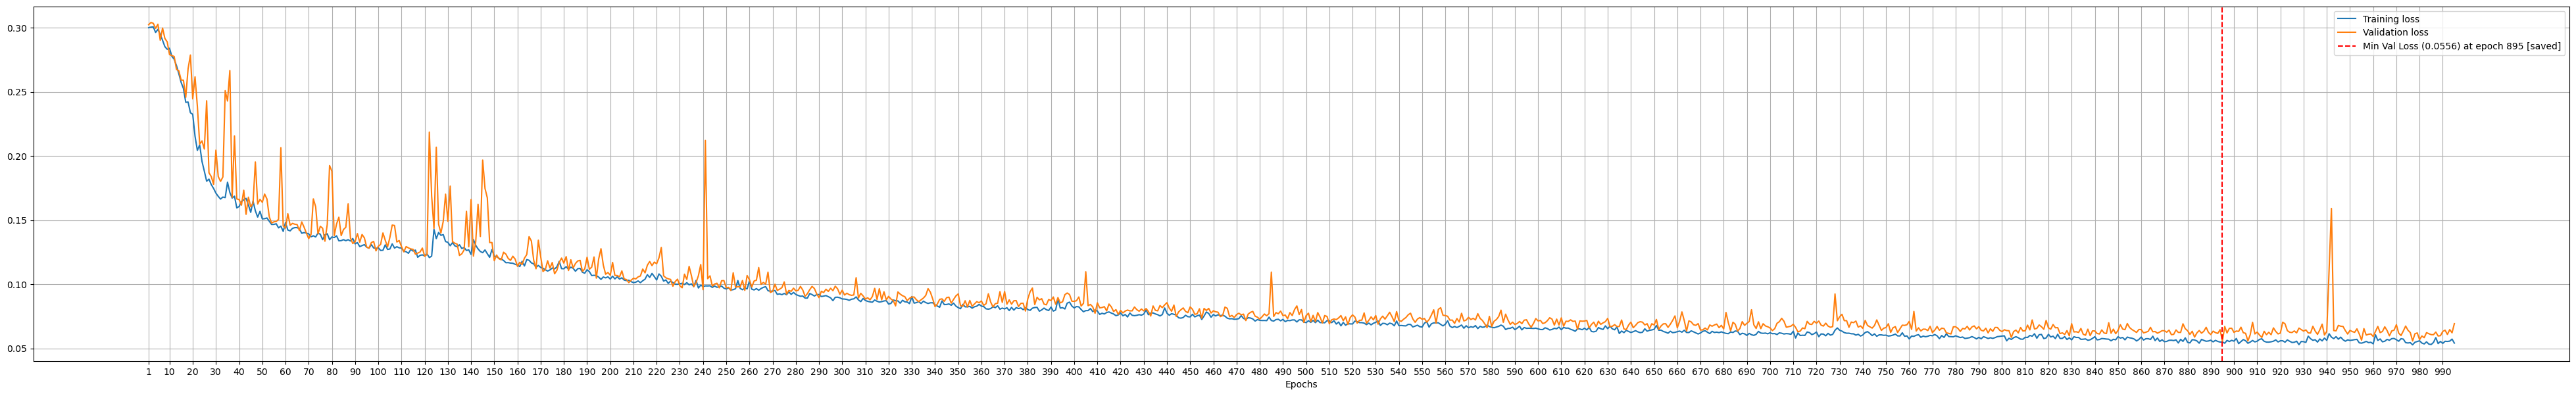

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

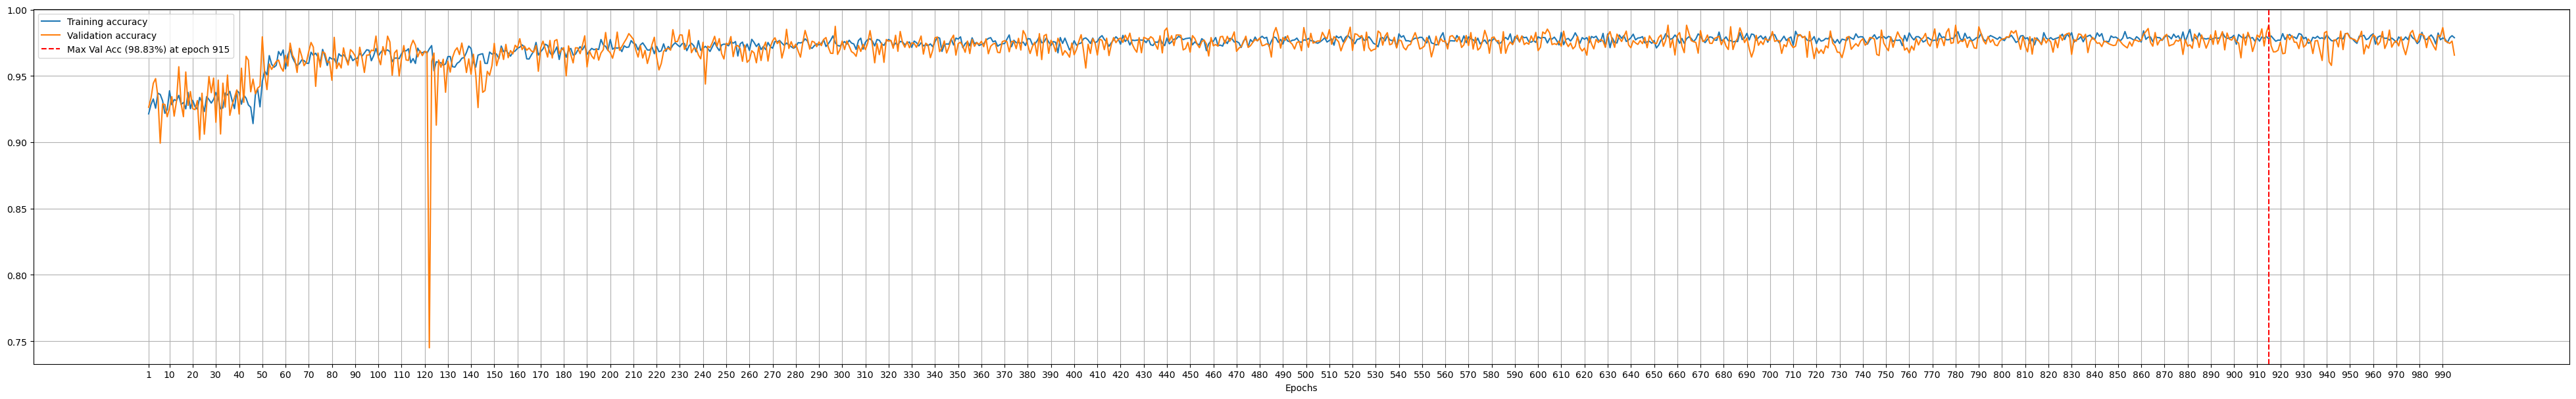

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/1st_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


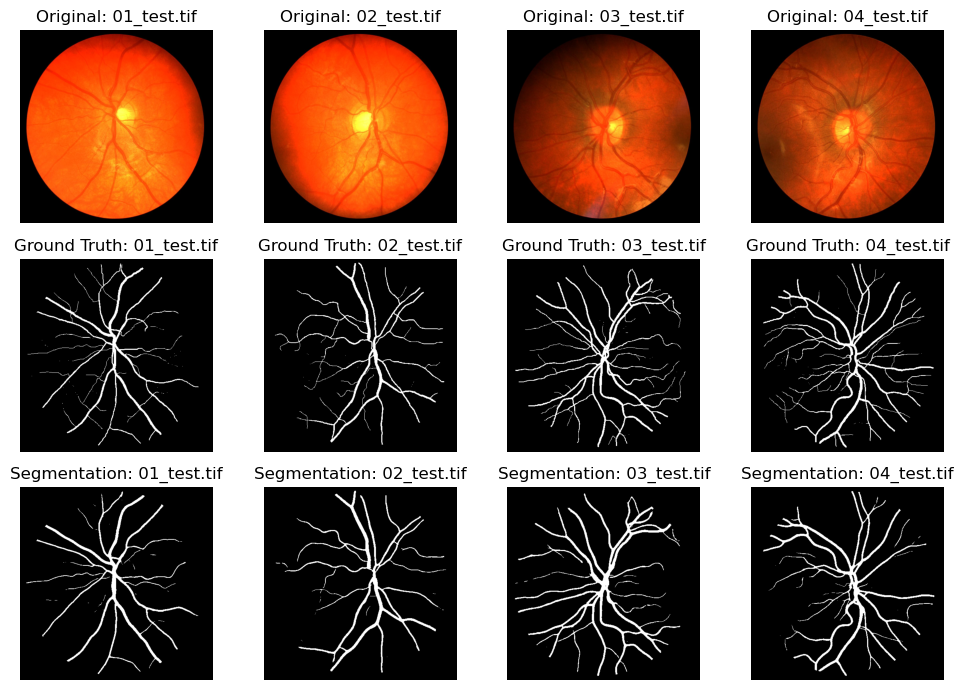

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

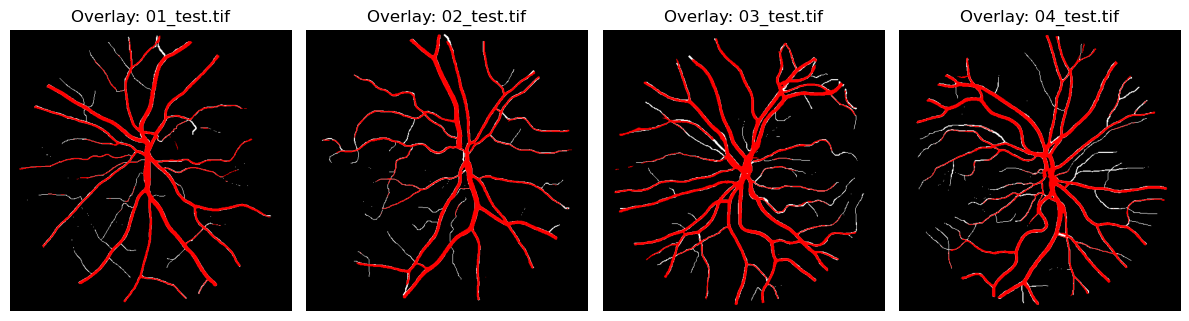

In [23]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.7939

MCC: 0.7805

ccDice score: 0.1152

Test Accuracy: 0.9733

F1 Score: 0.7933




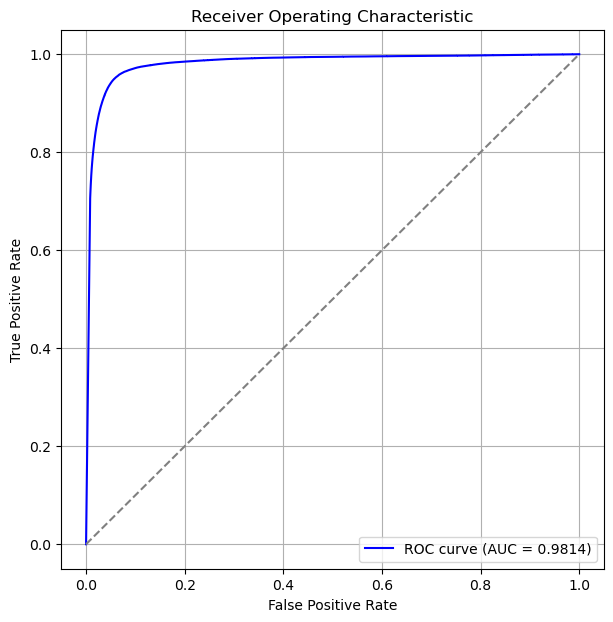

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_200044_ViGUNet_0.05556

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'